In [541]:
import os

import numpy as np
import pandas as pd

from scipy.optimize import basinhopping
from scipy.special import softmax

import rare_recurrence as rr
from importlib import reload
reload(rr)

import matplotlib.pyplot as plt

import matplotlib
import seaborn as sns

%matplotlib inline
    
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams["figure.facecolor"] = '#ffffff'

Download data from [here](https://doi.org/10.5281/zenodo.7659046) for use in this notebook.

In [199]:
## Import some R functions for calculating confidence intervales of Poisson ratios

from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
exactci = importr("exactci")

def calc_95_CI(X1, X2, N1, N2):
    CI = exactci.poisson_exact(FloatVector([X1, X2]), FloatVector([N1, N2]))
    return float(CI[4][0]), list(CI[3])

def calc_95_CI_single(X1, N1):
    CI = exactci.poisson_exact(float(X1), float(N1))
    return float(CI[4][0]), list(CI[3])

def add_estimates(data_mut):
    nbins = data_mut.shape[0]
    total_sites = data_mut.number_of_sites_no_SNV + data_mut.number_of_sites_SNV
    total_muts = data_mut.number_of_mutations_no_SNV + data_mut.number_of_mutations_SNV
    data_mut["total_sites"] = total_sites
    data_mut["total_muts"] = total_muts
    
    mu_ests, mu_upper_CI, mu_lower_CI = np.zeros(nbins), np.zeros(nbins), np.zeros(nbins)
    mu_poly_ests, mu_poly_upper_CI, mu_poly_lower_CI = np.zeros(nbins), np.zeros(nbins), np.zeros(nbins)
    mu_mono_ests, mu_mono_upper_CI, mu_mono_lower_CI = np.zeros(nbins), np.zeros(nbins), np.zeros(nbins)
    ratio_ests, ratio_upper_CI, ratio_lower_CI = np.zeros(nbins), np.zeros(nbins), np.zeros(nbins)
    for ii in range(nbins):
        mu_est = calc_95_CI_single(total_muts[ii], total_sites[ii])
        mu_ests[ii] = mu_est[0]
        mu_lower_CI[ii] = mu_est[1][0]
        mu_upper_CI[ii] = mu_est[1][1]
        
        mu_poly_est = calc_95_CI_single(data_mut.number_of_mutations_SNV[ii], data_mut.number_of_sites_SNV[ii])
        mu_poly_ests[ii] = mu_poly_est[0]
        mu_poly_lower_CI[ii] = mu_poly_est[1][0]
        mu_poly_upper_CI[ii] = mu_poly_est[1][1]
        
        mu_mono_est = calc_95_CI_single(data_mut.number_of_mutations_no_SNV[ii], data_mut.number_of_sites_no_SNV[ii])
        mu_mono_ests[ii] = mu_mono_est[0]
        mu_mono_lower_CI[ii] = mu_mono_est[1][0]
        mu_mono_upper_CI[ii] = mu_mono_est[1][1]
        
        ratio_est = calc_95_CI(data_mut.number_of_mutations_SNV[ii], data_mut.number_of_mutations_no_SNV[ii], 
                               data_mut.number_of_sites_SNV[ii], data_mut.number_of_sites_no_SNV[ii])
        ratio_ests[ii] = ratio_est[0]
        ratio_lower_CI[ii] = ratio_est[1][0]
        ratio_upper_CI[ii] = ratio_est[1][1]
        
        
    data_mut["mu_est"] = mu_ests
    data_mut["mu_95CI_lower"] = mu_lower_CI
    data_mut["mu_95CI_upper"] = mu_upper_CI
    
    data_mut["mu_poly_est"] = mu_poly_ests
    data_mut["mu_poly_95CI_lower"] = mu_poly_lower_CI
    data_mut["mu_poly_95CI_upper"] = mu_poly_upper_CI
    
    data_mut["mu_mono_est"] = mu_mono_ests
    data_mut["mu_mono_95CI_lower"] = mu_mono_lower_CI
    data_mut["mu_mono_95CI_upper"] = mu_mono_upper_CI
    
    data_mut["ratio_est"] = ratio_ests
    data_mut["ratio_95CI_lower"] = ratio_lower_CI
    data_mut["ratio_95CI_upper"] = ratio_upper_CI
    
    data_mut["prop_poly"] = data_mut.number_of_sites_SNV / data_mut.total_sites
    
def round_sig(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

In [22]:
data_dir = "./" #"../../../DATA/IGK/" 
IGK_col_names = ["pos", "context", "mu", "gene", "AC", "AN"]
IGK_col_names_denovo = ["pos", "context", "mu", "AC", "AN", "denovo"]

In [4]:
MU_SCALE = 1.015e-7
IGK_C = "#377eb8"
RNU_C = "#ff7f00"
tRNA_C = "#984ea3"

In [951]:
def process_sfs(fname, denovo=False):
    if not denovo:
        test_data = pd.read_csv(os.path.join(data_dir, fname), sep=" ", header=None, names=IGK_col_names)
    if denovo:
        test_data = pd.read_csv(os.path.join(data_dir, fname), sep=" ", header=None, names=IGK_col_names+["denovo"])
    test_data.loc[pd.isna(test_data.gene), "gene"] = "bk_high"
    return test_data

def ac_df(dd, name=None):
    nn = np.bincount(dd.AC.to_numpy())
    ac = np.arange(len(nn))
    return pd.DataFrame({"ac":ac, "nn":nn, "gene":name}) if name else pd.DataFrame({"ac":ac, "nn":nn})

def mu_count(MR, mu_vals):
    mu_dict = {}
    for mu_val in mu_vals:
        mu_dict[mu_val] = 0
    mu_obs, counts = np.unique(MR, return_counts=True)
    for ii, mu in enumerate(mu_obs):
        mu_dict[mu] = counts[ii]
    return mu_dict, mu_vals, 

def combine_sfs(sfs1, sfs2):
    sfs1_nn = sfs1.nn.to_numpy()
    sfs2_nn = sfs2.nn.to_numpy()
    if len(sfs1_nn) > len(sfs2_nn):
        sfs2_nn = np.concatenate((sfs2_nn, np.zeros(len(sfs1_nn) - len(sfs2_nn), dtype=np.int)))
        result = sfs1.copy()
        result.nn = sfs1.nn + sfs2_nn
        return result
    elif len(sfs2_nn) > len(sfs1_nn):
        sfs1_nn = np.concatenate((sfs1_nn, np.zeros(len(sfs2_nn) - len(sfs1_nn), dtype=np.int)))
        result = sfs2.copy()
        result.nn = sfs2.nn + sfs1_nn
        return result
    else:
        result = sfs1.copy()
        result.nn = sfs1.nn + sfs2.nn
        return result
    
def gene_type(gene_name):
    if "IGK" in gene_name:
        return "IGK"
    elif "RNU" in gene_name:
        return "RNU"
    elif "tRNA" in gene_name:
        return "tRNA"
    else:
        return "bk_high"
    
def nonzero(dd):
    return dd.loc[dd.nn>0]

def poly_norm(nn):
    # assume first entry is zero
    return nn[1:]/np.sum(nn[1:])

def multinomial_trans(sfs_probs, offset=None):
    sfs_probs = np.array(sfs_probs)
    P_0 = sfs_probs[...,0]
    if offset:
        betas = np.log(sfs_probs[...,1:]) - np.log(P_0[...,None]) - offset
    else:
        betas = np.log(sfs_probs[...,1:]) - np.log(P_0[...,None])
    return betas

def softmax_trans(beta):
    return softmax(np.concatenate(([0], beta)))

def sample_mu(data, mu_vals, reps):
    mu_set, mu_counts = np.unique(mu_vals, return_counts=True)
    mu_inds = [np.where(data.MR==mu)[0] for mu in mu_set]
    rand_inds = [ np.concatenate([[np.random.choice(mu_inds[ii], mu_counts[ii], replace=True)] for _ in range(reps)]) for ii, mu in enumerate(mu_set)]
    data_matched = []
    for rep in range(reps):
        all_inds = []
        for rand_ind in rand_inds:
            all_inds = np.concatenate((all_inds, rand_ind[rep]))
        data_matched.append(data.iloc[all_inds])
    return data_matched

vlen = np.vectorize(len)

In [6]:
# Little test that combine_sfs works
test_sfs1 = pd.DataFrame({"ac":[0,1,2,3],   "nn":[1,1,1,1]})
test_sfs2 = pd.DataFrame({"ac":[0,1,2,3,4], "nn":[2,2,2,2,2]})
print(combine_sfs(test_sfs1, test_sfs2))

test_sfs1 = pd.DataFrame({"ac":[0,1,2,3],   "nn":[1,1,1,1]})
test_sfs2 = pd.DataFrame({"ac":[0,1,2,3], "nn":[2,2,2,2]})
print(combine_sfs(test_sfs1, test_sfs2))

   ac  nn
0   0   3
1   1   3
2   2   3
3   3   3
4   4   2
   ac  nn
0   0   3
1   1   3
2   2   3
3   3   3


In [7]:
# Define SFS bins for use in the analysis
sfs_bins = rr.make_bins(5, 3, 154000, incl_zero=True)
sfs_bin_means = rr.bin_means(sfs_bins)
sfs_bin_sizes = rr.bin_sizes(sfs_bins)

In [8]:
sfs_bins, sfs_bin_sizes

(array([     0,      1,      2,      3,      4,      5,      9,     27,
            81,    243,    729,   2187,   6561,  19683,  59049,  77000,
        154000]),
 array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 1.8000e+01, 5.4000e+01, 1.6200e+02, 4.8600e+02,
        1.4580e+03, 4.3740e+03, 1.3122e+04, 3.9366e+04, 1.7951e+04,
        7.7000e+04]))

In [488]:
bk_high_mu_sfs = {}
for ii in range(1,23):
    print(ii)
    fname = str(ii) + "_IGK_SFS_v2.gz"
    sfs_data = process_sfs(fname)
    sfs_data = sfs_data.loc[sfs_data.gene=="bk_high"]
    mutation_rates = np.unique(sfs_data.mu.to_numpy())
    for mu in mutation_rates:
        mu_data = sfs_data.loc[sfs_data.mu==mu]
        mu_sfs = ac_df(mu_data, name="bk_high")
        if str(mu) in bk_high_mu_sfs.keys():
            bk_high_mu_sfs[str(mu)] = combine_sfs(bk_high_mu_sfs[str(mu)], mu_sfs)
        else:
            bk_high_mu_sfs[str(mu)] = mu_sfs

1


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


2


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


3


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


4


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


5


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


6


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


7


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


8


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


9


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


10


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


11


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


12


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


13


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


14


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


15


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


16


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


17
18


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


19
20


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


21


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


22


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [9]:
fname = "22_IGK_SFS_v2.gz"
test_data = process_sfs(fname)
test_data = test_data.loc[test_data.gene!="bk_high"]

/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [29]:
denovo_test = process_sfs("1_IGK_SFS_v2_denovo.gz", denovo=True)

/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [31]:
denovo_test.size

13921551

In [74]:
gene_types = np.array([gene_type(gene) for gene in test_data.gene])

In [744]:
RNU_positions = []
tRNA_positions = []
IGK_positions= []
for ii in range(1,23):
    print(ii)
    fname = str(ii) + "_IGK_SFS_v2.gz"
    sfs_data = process_sfs(fname)
    sfs_data = sfs_data.loc[sfs_data.gene!="bk_high"]
    gene_types = np.array([gene_type(gene) for gene in sfs_data.gene])
    RNU_positions += list(sfs_data.loc[gene_types=="RNU"].pos)
    tRNA_positions += list(sfs_data.loc[gene_types=="tRNA"].pos)
    IGK_positions += list(sfs_data.loc[gene_types=="IGK"].pos)

1


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [76]:
gene_types.size, test_data.size

(1800, 10800)

In [44]:
denovo_list = []
for ii in range(1,23):
    fname = str(ii) + "_IGK_SFS_v2_denovo.gz"
    denovo_data = process_sfs(fname, denovo=True)
    denovo_data = denovo_data.loc[denovo_data.gene!="bk_high"]
    denovo_list.append(denovo_data)

/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [45]:
denovo_gene_table = pd.concat(denovo_list)
denovo_gene_table["gene_class"] = [gene_type(gene) for gene in denovo_gene_table.gene]

In [220]:
denovo_gene_table.head()

,pos,context,mu,gene,AC,AN,denovo,gene_class,sites,poly
78940,4566900,ATCCT_A,0.083,tRNA-Und-NNN-chr1-1,3,151570,0,tRNA,1,True
78941,4566900,ATCCT_G,0.041,tRNA-Und-NNN-chr1-1,0,0,0,tRNA,1,False
78942,4566900,ATCCT_T,0.163,tRNA-Und-NNN-chr1-1,0,0,0,tRNA,1,False
78943,4566901,TCCTT_A,0.041,tRNA-Und-NNN-chr1-1,1,147364,0,tRNA,1,True
78944,4566901,TCCTT_G,0.041,tRNA-Und-NNN-chr1-1,0,0,0,tRNA,1,False


In [460]:
def get_dn(context):
    return context[2]+context[6]
def get_ti(context):
    return (context[2]+context[6]) in ["CT", "TC"]
denovo_gene_table["ti"] = denovo_gene_table.apply(lambda row: get_ti(row["context"]), axis=1)

In [462]:
denovo_gene_table.head()

,pos,context,mu,gene,AC,AN,denovo,gene_class,sites,poly,hypermutable,ti
0,4566900,ATCCT_A,0.083,tRNA-Und-NNN-chr1-1,3,151570,0,tRNA,1,True,False,False
1,4566900,ATCCT_G,0.041,tRNA-Und-NNN-chr1-1,0,0,0,tRNA,1,False,False,False
2,4566900,ATCCT_T,0.163,tRNA-Und-NNN-chr1-1,0,0,0,tRNA,1,False,False,True
3,4566901,TCCTT_A,0.041,tRNA-Und-NNN-chr1-1,1,147364,0,tRNA,1,True,False,False
4,4566901,TCCTT_G,0.041,tRNA-Und-NNN-chr1-1,0,0,0,tRNA,1,False,False,False


In [63]:
denovo_gene_table["sites"] = 1
denovo_gene_table["poly"] = denovo_gene_table.AC>0
denovo_class_table = denovo_gene_table[["gene_class", "poly", "sites", "denovo"]].groupby(["gene_class", "poly"]).sum()
denovo_class_table

sites  denovo
gene_class poly                 
IGK        False   24470       0
           True     4240       0
RNU        False   18367       0
           True     8963      18
tRNA       False  480974      39
           True    86782      64

In [418]:
bygene = denovo_gene_table[["gene_class", "gene", "sites", "poly", "denovo"]].groupby(["gene"]).sum().reset_index()
bygene["gene_class"] = [gene_type(gene) for gene in bygene.gene]
bygene["prob_poly"] = (bygene.poly) / bygene.sites

In [774]:
bygene.head()

,gene,sites,poly,denovo,gene_class,prob_poly,est_rate,lower,upper,hypermutable
0,IGKC,2400,194,0,IGK,0.080833,0.080833,0.069858,0.093043,False
1,IGKJ1,600,96,0,IGK,0.160000,0.160000,0.129601,0.195387,False
2,IGKV1-27,1920,288,0,IGK,0.150000,0.150000,0.133175,0.168363,False
3,IGKV1-5,300,160,0,IGK,0.533333,0.533333,0.453895,0.622674,True
4,IGKV1-6,600,75,0,IGK,0.125000,0.125000,0.098320,0.156689,False


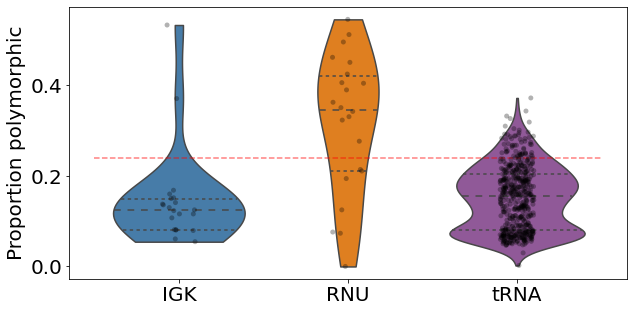

In [775]:
sns.set_palette([IGK_C, RNU_C, tRNA_C])
fig, ax = plt.subplots(figsize=(10,5))
sns.violinplot(data=bygene, x="gene_class", y="prob_poly", inner="quartile", ax=ax, cut=0)
sns.stripplot(data=bygene, x="gene_class", y="prob_poly", jitter=True, ax=ax, color="black", alpha=0.3)
ax.plot([-0.5, 2.5], [0.24, 0.24], "--", color="red", alpha=0.5) 
ax.set_xlabel(None)
ax.set_ylabel("Proportion polymorphic")
fig.savefig("gene_classes_prop_poly.pdf", bbox_inches="tight")

In [421]:
pois_CI_gene = [calc_95_CI_single(*x) for x in zip(bygene.poly, bygene.sites)]
bygene["est_rate"] = [x[0] for x in pois_CI_gene]
bygene["lower"] = [x[1][0] for x in pois_CI_gene]
bygene["upper"] = [x[1][1] for x in pois_CI_gene]

In [422]:
def plot_genes_poly(gc, ax, color="black", horiz=0.24):
    bygene_tmp = bygene.loc[bygene.gene_class==gc]
    gc_ord = np.argsort(bygene_tmp.est_rate).to_numpy()
    ax.plot(np.array([[x]*2 for x in range(len(gc_ord))]).T, 
             np.array([bygene_tmp.lower.to_numpy()[gc_ord], 
                       bygene_tmp.upper.to_numpy()[gc_ord]]), "-", color="grey");
    ax.plot(bygene_tmp.est_rate.to_numpy()[gc_ord], "o", color=color)
    ax.plot([0, len(gc_ord)], [horiz]*2, "--", color="red")

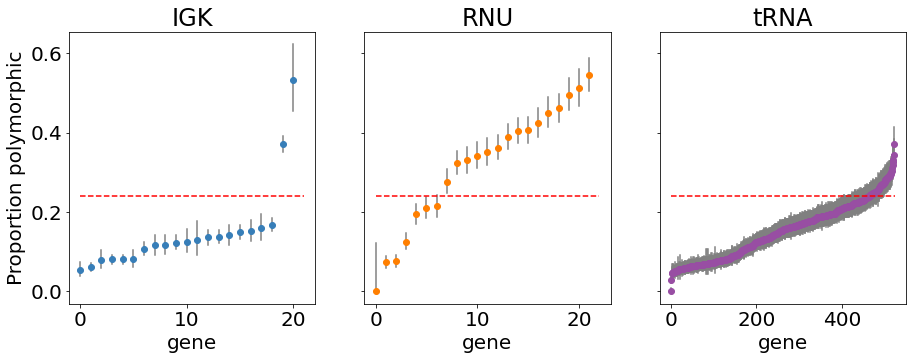

In [423]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
plot_genes_poly("IGK", axes[0], IGK_C)
plot_genes_poly("RNU", axes[1], RNU_C)
plot_genes_poly("tRNA", axes[2], tRNA_C)
[(axes[i].set_title(gene_classes[i]), axes[i].set_xlabel("gene")) for i in range(3)]
axes[0].set_ylabel("Proportion polymorphic")
fig.savefig("gene_classes_prop_poly_bars.pdf", bbox_inches="tight")

In [425]:
bygene.head()

,gene,sites,poly,denovo,gene_class,prob_poly,est_rate,lower,upper,hypermutable
0,IGKC,2400,194,0,IGK,0.080833,0.080833,0.069858,0.093043,False
1,IGKJ1,600,96,0,IGK,0.160000,0.160000,0.129601,0.195387,False
2,IGKV1-27,1920,288,0,IGK,0.150000,0.150000,0.133175,0.168363,False
3,IGKV1-5,300,160,0,IGK,0.533333,0.533333,0.453895,0.622674,True
4,IGKV1-6,600,75,0,IGK,0.125000,0.125000,0.098320,0.156689,False


In [430]:
bygene["ti"] = bygene.est_rate > 0.24
bygene[["gene_class", "ti", "poly", "sites", "denovo"]].groupby(["gene_class", "ti"]).sum()

poly   sites  denovo
gene_class hypermutable                       
IGK        False          2856   25110       0
           True           1384    3600       0
RNU        False          1117    7830       0
           True           7846   19500      18
tRNA       False         70318  507486      78
           True          16464   60270      25

In [436]:
bygene.head()

,gene,sites,poly,denovo,gene_class,prob_poly,est_rate,lower,upper,hypermutable
0,IGKC,2400,194,0,IGK,0.080833,0.080833,0.069858,0.093043,False
1,IGKJ1,600,96,0,IGK,0.160000,0.160000,0.129601,0.195387,False
2,IGKV1-27,1920,288,0,IGK,0.150000,0.150000,0.133175,0.168363,False
3,IGKV1-5,300,160,0,IGK,0.533333,0.533333,0.453895,0.622674,True
4,IGKV1-6,600,75,0,IGK,0.125000,0.125000,0.098320,0.156689,False


In [441]:
denovo_gene_table = denovo_gene_table.merge(bygene[["gene", "ti"]], on="gene")

In [991]:
denovo_class_table

sites  denovo  est_denovo_rate  est_denovo_lower  \
gene_class poly                                                       
IGK        False   24470       0         0.000000          0.000000   
           True     4240       0         0.000000          0.000000   
RNU        False   18367       0         0.000000          0.000000   
           True     8963      18         0.002008          0.001190   
tRNA       False  480974      39         0.000081          0.000058   
           True    86782      64         0.000737          0.000568   

                  est_denovo_upper  
gene_class poly                     
IGK        False          0.000151  
           True           0.000870  
RNU        False          0.000201  
           True           0.003174  
tRNA       False          0.000111  
           True           0.000942

In [463]:
denovo_ti_table = denovo_gene_table[["gene_class", "ti", "poly", "sites", "denovo"]].groupby(["gene_class", "ti", "poly"]).sum()
denovo_ti_table

sites  denovo
gene_class ti    poly                 
IGK        False False   17082       0
                 True     2058       0
           True  False    7388       0
                 True     2182       0
RNU        False False   13861       0
                 True     4359       4
           True  False    4506       0
                 True     4604      14
tRNA       False False  342002      21
                 True    36502      15
           True  False  138972      18
                 True    50280      49

In [80]:
pois_CI_classes = [calc_95_CI_single(x[0], x[1]) for x in zip(denovo_class_table.denovo, denovo_class_table.sites)]
denovo_class_table["est_denovo_rate"] = [x[0] for x in pois_CI_classes]
denovo_class_table["est_denovo_lower"] = [x[1][0] for x in pois_CI_classes]
denovo_class_table["est_denovo_upper"] = [x[1][1] for x in pois_CI_classes]

In [989]:
pois_CI_classes_ti = [calc_95_CI_single(x[0], x[1]) for x in zip(denovo_ti_table.denovo, denovo_ti_table.sites)]
denovo_ti_table["est_denovo_rate"] = [x[0] for x in pois_CI_classes_ti]
denovo_ti_table["est_denovo_lower"] = [x[1][0] for x in pois_CI_classes_ti]
denovo_ti_table["est_denovo_upper"] = [x[1][1] for x in pois_CI_classes_ti]

In [990]:
denovo_ti_table

sites  denovo  est_denovo_rate  est_denovo_lower  \
gene_class ti    poly                                                       
IGK        False False   17082       0         0.000000          0.000000   
                 True     2058       0         0.000000          0.000000   
           True  False    7388       0         0.000000          0.000000   
                 True     2182       0         0.000000          0.000000   
RNU        False False   13861       0         0.000000          0.000000   
                 True     4359       4         0.000918          0.000250   
           True  False    4506       0         0.000000          0.000000   
                 True     4604      14         0.003041          0.001662   
tRNA       False False  342002      21         0.000061          0.000038   
                 True    36502      15         0.000411          0.000230   
           True  False  138972      18         0.000130          0.000077   
                 True    50280      49         0.000975          0.000721   

                        est_denovo_upper  
gene_class ti    poly                     
IGK        False False          0.000216  
                 True           0.001792  
           True  False          0.000499  
                 True           0.001691  
RNU        False False          0.000266  
                 True           0.002350  
           True  False          0.000819  
                 True           0.005102  
tRNA       False False          0.000094  
                 True           0.000678  
           True  False          0.000205  
                 True           0.001288

In [117]:
denovo_roulette = pd.read_csv("variance_roulette", delim_whitespace=True)
denovo_roulette = data_roulette[~np.isnan(data_roulette.rate_SNV_div_rate_no_SNV)].reset_index()
denovo_roulette.head()

,level_0,index,predicted_rate,number_of_mutations_no_SNV,number_of_sites_no_SNV,number_of_mutations_SNV,number_of_sites_SNV,rate_SNV_div_rate_no_SNV
0,0,1,0.013,3642,455867042,57,5552885,1.284856
1,1,2,0.020,17711,1407704153,490,27363779,1.423273
2,2,3,0.030,19607,1058844151,785,30520404,1.388994
3,3,4,0.041,17611,703786249,895,27449664,1.302995
4,4,5,0.051,16133,510324931,1050,25310121,1.312281


In [118]:
add_estimates(denovo_roulette)

In [179]:
denovo_roulette.tail()

,level_0,index,predicted_rate,number_of_mutations_no_SNV,number_of_sites_no_SNV,number_of_mutations_SNV,number_of_sites_SNV,rate_SNV_div_rate_no_SNV,total_sites,total_muts,...,mu_poly_est,mu_poly_95CI_lower,mu_poly_95CI_upper,mu_mono_est,mu_mono_95CI_lower,mu_mono_95CI_upper,ratio_est,ratio_95CI_lower,ratio_95CI_upper,prop_poly
93,93,94,2.813,177,115872,2756,1313635,1.373440,1429507,2933,...,0.002098,0.002020,0.002178,0.001528,0.001311,0.001770,1.373440,1.179430,1.608038,0.918943
94,94,95,2.996,120,65788,1966,878953,1.226262,944741,2086,...,0.002237,0.002139,0.002338,0.001824,0.001512,0.002181,1.226262,1.019486,1.487020,0.930364
95,95,96,3.219,56,29782,1204,495192,1.293060,524974,1260,...,0.002431,0.002296,0.002573,0.001880,0.001420,0.002442,1.293060,0.988924,1.722138,0.943270
96,96,97,3.507,13,6306,356,138031,1.251077,144337,369,...,0.002579,0.002318,0.002861,0.002062,0.001098,0.003525,1.251077,0.722245,2.372866,0.956311
97,97,98,3.912,2,1034,81,31372,1.334853,32406,83,...,0.002582,0.002050,0.003209,0.001934,0.000234,0.006987,1.334853,0.357798,11.209731,0.968092


In [168]:
denovo_class_table

sites  denovo  est_denovo_rate  est_denovo_lower  \
gene_class poly                                                       
IGK        False   24470       0         0.000000          0.000000   
           True     4240       0         0.000000          0.000000   
RNU        False   18367       0         0.000000          0.000000   
           True     8963      18         0.002008          0.001190   
tRNA       False  480974      39         0.000081          0.000058   
           True    86782      64         0.000737          0.000568   

                  est_denovo_upper  
gene_class poly                     
IGK        False          0.000151  
           True           0.000870  
RNU        False          0.000201  
           True           0.003174  
tRNA       False          0.000111  
           True           0.000942

In [493]:
gene_sfs_set = {}
for ii in range(1,23):
    print(ii)
    fname = str(ii) + "_IGK_SFS_v2.gz"
    sfs_data = process_sfs(fname)
    genes = np.unique(sfs_data.gene)
    for gene in genes:
        if gene == "bk_high":
            continue
        gene_chr = gene + "_chr" + str(ii)
        gene_data = sfs_data.loc[sfs_data.gene==gene]
        gene_sfs = ac_df(gene_data, name=gene_chr)
        gene_sfs["gene_type"] = gene_type(gene)
        gene_sfs_set[gene_chr] = gene_sfs

1


/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [494]:
gene_mu_set = {}
for ii in range(1,23):
    fname = str(ii) + "_IGK_SFS_v2.gz"
    sfs_data = process_sfs(fname)
    genes = np.unique(sfs_data.gene)
    for gene in genes:
        if gene == "bk_high":
            continue
        gene_chr = gene + "_chr" + str(ii)
        gene_data = sfs_data.loc[sfs_data.gene==gene]
        gene_mu_set[gene_chr] = gene_data.mu.to_numpy()

In [497]:
genes = list(gene_sfs_set.keys())

In [498]:
genes[0:10]

['RNU1-1_chr1',
 'RNU1-2_chr1',
 'RNU11_chr1',
 'RNU5D-1_chr1',
 'RNU5E-1_chr1',
 'RNU5F-1_chr1',
 'nm-tRNA-Tyr-ATA-chr1-10_chr1',
 'nm-tRNA-Tyr-ATA-chr1-64_chr1',
 'nmt-tRNA-Pro-TGG-1-1_chr1',
 'tRNA-Ala-AGC-20-1_chr1']

In [499]:
gene_sfs_set["RNU1-1_chr1"].head()

,ac,nn,gene,gene_type
0,0,789,RNU1-1_chr1,RNU
1,1,124,RNU1-1_chr1,RNU
2,2,68,RNU1-1_chr1,RNU
3,3,41,RNU1-1_chr1,RNU
4,4,20,RNU1-1_chr1,RNU


In [500]:
gene_types = np.array([gene_sfs_set[gene].gene_type[0] for gene in genes])

In [501]:
np.unique(gene_types)

array(['IGK', 'RNU', 'tRNA'], dtype='<U4')

In [503]:
gene_type_sfs = {}
for ii, gene in enumerate(genes):
    if not gene_types[ii] in gene_type_sfs.keys():
        gene_type_sfs[gene_types[ii]] = gene_sfs_set[gene]
    else:
        gene_type_sfs[gene_types[ii]] = combine_sfs(gene_type_sfs[gene_types[ii]], gene_sfs_set[gene])

In [504]:
gene_type_mu = {}
for ii, gene in enumerate(genes):
    if not gene_types[ii] in gene_type_mu.keys():
        gene_type_mu[gene_types[ii]] = gene_mu_set[gene]
    else:
        gene_type_mu[gene_types[ii]] = np.concatenate((gene_type_mu[gene_types[ii]], gene_mu_set[gene]))

In [506]:
gene_sfs_binned = [rr.bin_data(nonzero(gene_sfs_set[gene]).ac, nonzero(gene_sfs_set[gene]).nn, sfs_bins) for gene in genes]

In [507]:
gene_type_sfs_binned = [rr.bin_data(gene_type_sfs[gene_type].ac, gene_type_sfs[gene_type].nn, sfs_bins) for gene_type in np.unique(gene_types)]

In [513]:
data_21 = pd.read_csv(os.path.join(data_dir, "all_variants_chr21_mu_h.csv.gz"))

In [514]:
data_21.head()

,POS,REF,ALT,FILTER,AC,AN,n_alt_alleles,nhomalt,variant_type,DP,...,AS_pab_max,AS_QD,AS_ReadPosRankSum,AS_SOR,mu_qual,PN,MR,AR,MG,MC
0,5030253,G,T,AS_VQSR,1,5170,1,0,snv,22,...,1.0,14.4545,0.550,0.874090,low,TGGAT,0.094,NaN,0.045,NaN
1,5030278,C,G,AS_VQSR,1,8212,2,0,multi-snv,669,...,1.0,19.3825,0.358,1.356830,low,CACGG,0.083,NaN,0.085,NaN
2,5030319,C,G,AS_VQSR,3,16778,2,0,multi-snv,664,...,1.0,14.1929,0.358,0.646736,low,CCCGA,0.151,NaN,0.087,NaN
3,5030319,C,T,AS_VQSR,2,16778,2,0,multi-snv,664,...,1.0,17.8128,0.000,0.168623,low,CCCGA,1.772,NaN,1.877,NaN
4,5030347,G,A,AS_VQSR,11,23230,2,0,multi-snv,593,...,1.0,17.5232,0.466,1.270550,low,ACGGC,1.514,NaN,1.877,NaN


In [515]:
data_21 = data_21.loc[(data_21.FILTER=="PASS") & 
                      (data_21.mu_qual!="low") & 
                      (data_21.mu_qual!="SFS_bump") & 
                      (vlen(data_21.REF)==1) & 
                      (vlen(data_21.ALT)==1) & 
                      (data_21.MR!=".")]

In [516]:
data_21.head()

,POS,REF,ALT,FILTER,AC,AN,n_alt_alleles,nhomalt,variant_type,DP,...,AS_pab_max,AS_QD,AS_ReadPosRankSum,AS_SOR,mu_qual,PN,MR,AR,MG,MC
360218,8989412,C,T,PASS,9481,67832,1,0,snv,4485598,...,1.000000e+00,5.97969,-0.216,0.754916,TFBS,CGCAG,0.128,NaN,0.128,NaN
360219,8989415,G,T,PASS,1,152258,2,0,mixed,4049,...,8.953880e-08,1.38882,0.574,0.643956,TFBS,AGGGA,0.030,NaN,0.048,NaN
360221,8989426,C,G,PASS,1,150248,5,0,mixed,438492,...,8.412320e-08,3.75294,-0.264,0.678365,TFBS,TACAT,0.020,NaN,0.046,NaN
360223,8989433,C,T,PASS,187,146100,4,0,mixed,712772,...,2.006780e-01,1.39892,0.533,0.746774,TFBS,ACCAT,0.163,NaN,0.122,NaN
360224,8989442,G,A,PASS,29,148914,3,0,multi-snv,295395,...,1.203440e-04,1.11296,0.377,0.718900,TFBS,TTGTT,0.163,NaN,0.179,NaN


In [517]:
all_mu = np.unique(data_21.MR.to_numpy())
all_mu

array([0.004, 0.013, 0.02 , 0.03 , 0.041, 0.051, 0.062, 0.073, 0.083,
       0.094, 0.105, 0.117, 0.128, 0.139, 0.151, 0.163, 0.174, 0.186,
       0.198, 0.211, 0.223, 0.236, 0.248, 0.261, 0.274, 0.288, 0.301,
       0.315, 0.329, 0.342, 0.357, 0.371, 0.386, 0.4  , 0.416, 0.431,
       0.446, 0.462, 0.478, 0.494, 0.511, 0.528, 0.545, 0.562, 0.58 ,
       0.598, 0.616, 0.635, 0.654, 0.673, 0.693, 0.713, 0.734, 0.755,
       0.777, 0.799, 0.821, 0.844, 0.868, 0.892, 0.916, 0.942, 0.968,
       0.994, 1.022, 1.05 , 1.079, 1.109, 1.139, 1.171, 1.204, 1.238,
       1.273, 1.309, 1.347, 1.386, 1.427, 1.47 , 1.514, 1.561, 1.609,
       1.661, 1.715, 1.772, 1.833, 1.897, 1.966, 2.04 , 2.12 , 2.207,
       2.303, 2.408, 2.526, 2.659, 2.813, 2.996, 3.219, 3.507, 3.912])

In [519]:
mu_sfs_21 = {}
for ii, mu in enumerate(all_mu):
    data_mu = data_21.loc[data_21.MR==mu]
    sfs_mu = ac_df(data_mu, name="mu_"+str(mu))
    mu_sfs_21[str(mu)] = sfs_mu

In [520]:
mu_sfs_21[str(all_mu[0])].head()

,ac,nn,gene
0,0,0,mu_0.004
1,1,0,mu_0.004
2,2,0,mu_0.004
3,3,0,mu_0.004
4,4,0,mu_0.004


In [521]:
mu_sfs_21_binned = [rr.bin_data(nonzero(mu_sfs_21[str(mu)]).ac, nonzero(mu_sfs_21[str(mu)]).nn, sfs_bins) for mu in all_mu]

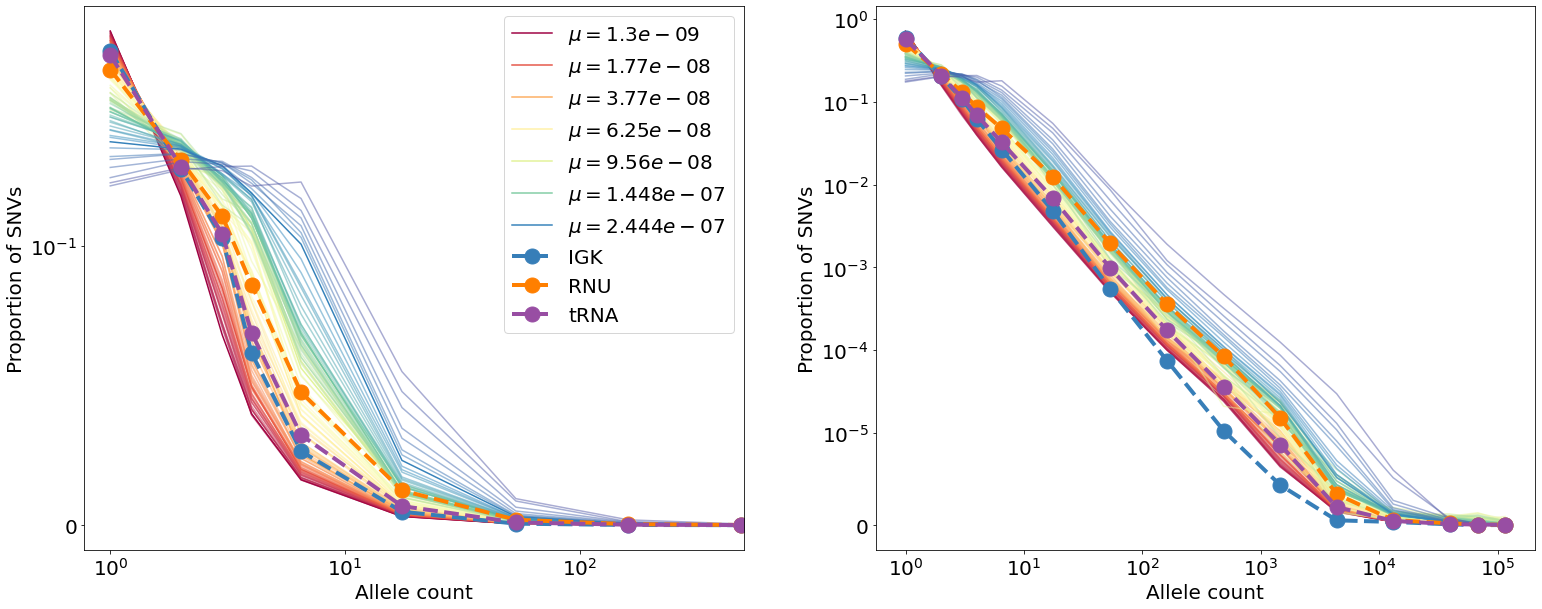

In [533]:
fig, axes = plt.subplots(1, 2, figsize=(26,10))

import matplotlib as mpl
cmap = mpl.cm.get_cmap("Spectral", 500)

for ii, mu in enumerate(all_mu[1:]):
    mu_sfs_binned = mu_sfs_21_binned[ii+1]
    mu_sfs_binned = mu_sfs_binned / sfs_bin_sizes / np.sum(mu_sfs_binned)
    axes[1].plot(sfs_bin_means[1:], poly_norm(mu_sfs_binned), "-", alpha=0.5, color=cmap(ii/len(all_mu)))
    if ii % 15:
        axes[0].plot(sfs_bin_means[1:], poly_norm(mu_sfs_binned), "-", alpha=0.5, color=cmap(ii/len(all_mu)))
    else:
        axes[0].plot(sfs_bin_means[1:], poly_norm(mu_sfs_binned), "-", alpha=1, color=cmap(ii/len(all_mu)), label=r"$\mu={}$".format(str(round(mu*1.015e-7, 10))))

axes[0].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[0]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[0])), 
        "o--", c="#377eb8", linewidth=4, markersize=15, label=np.unique(gene_types)[0])
axes[0].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[1]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[1])), 
        "o--", c="#ff7f00", linewidth=4, markersize=15, label=np.unique(gene_types)[1])
axes[0].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[2]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[2])), 
        "o--", c="#984ea3", linewidth=4, markersize=15, label=np.unique(gene_types)[2])

axes[1].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[0]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[0])), 
        "o--", c="#377eb8", linewidth=4, markersize=15, label=np.unique(gene_types)[0])
axes[1].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[1]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[1])), 
        "o--", c="#ff7f00", linewidth=4, markersize=15, label=np.unique(gene_types)[1])
axes[1].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[2]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[2])), 
        "o--", c="#984ea3", linewidth=4, markersize=15, label=np.unique(gene_types)[2])

axes[0].set_yscale("symlog", linthresh=1e-1)
axes[0].set_xscale("symlog", linthresh=1)
axes[0].legend()

axes[1].set_yscale("symlog", linthresh=1e-5)
axes[1].set_xscale("symlog", linthresh=1)

axes[0].set_xlim(0.9, 5e2)

axes[0].set_ylabel("Proportion of SNVs")
axes[0].set_xlabel("Allele count")

axes[1].set_ylabel("Proportion of SNVs")
axes[1].set_xlabel("Allele count")

fig.savefig("IGK_sfs_mu_compare.pdf", bbox_inches="tight")

In [534]:
# Ignore first and last few bins because these have too few sites
mu_21_fit_set = np.array(mu_sfs_21_binned[1:-2])
mu_21_fit_set.shape

(96, 16)

In [535]:
# Noramlize the SFS to a probability distribution
mu_21_norm = (mu_21_fit_set.T / np.sum(mu_21_fit_set, 1))[1:,:]
mu_21_norm.shape

(15, 96)

In [536]:
# Calculate the overall distribution of mutation rates
overall_dist = np.unique(data_21.MR, return_counts=True)[1][1:-2]
overall_dist = overall_dist / np.sum(overall_dist)

In [537]:
mu_vals_fit = np.unique(data_21.MR, return_counts=True)[0][1:-2]

To estimate the distribution of mutation rates within a class of sites, we fit the allele frequency distribution as a mixture of the observed allele frequencies in each mutation rate bin.

\begin{equation*}
p_{\mathrm{class}}(AC) = \sum_{i=1}^{n_{\mathrm{bins}}} p_{\mu_i} p(AC|\mu_i)
\end{equation*}

Estimate $\{p_{mu_i}\}$ using maximum likelihood with a penalty on $c\times\sum_{i=0}^{n_{\mathrm{bins}}-1} (\beta_i - \beta_{i+1})^2$, where $\beta_i$ is the coefficient from the multinomial transformation of $\{p_{mu_i}\}$. Investigate results without smoothing $c=0$ and relatively strong smoothing $c=1000$.

Test on the bin probabilities from chromosome 21 to see that this approach gives reasonable results.

In [544]:
sfs_21 = ac_df(data_21)
sfs_21_binned = rr.bin_data(nonzero(sfs_21).ac, nonzero(sfs_21).nn, sfs_bins)

In [531]:
def f_21(x):
    xp = softmax_trans(x)
    pp = np.matmul(mu_21_norm, xp)
    return -np.sum(np.log(pp) * sfs_21_binned[1:]) + np.sum(np.diff(xp)**2)*1000
 
fit_21 = basinhopping(f_21, np.zeros(95), niter=100, minimizer_kwargs={"method":"L-BFGS-B"})

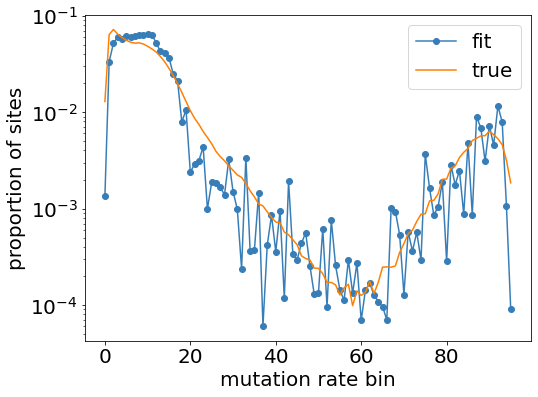

In [876]:
fig, _ = plt.subplots(figsize=(8,6))
plt.plot(softmax_trans(fit_21['x']), "-o", label="fit")
plt.plot(overall_dist, label="true")
plt.legend()
plt.yscale("log")
plt.xlabel("mutation rate bin")
plt.ylabel("proportion of sites");

This does look very reasonable, though perhaps over-smoothed at low mutation rates.

In [806]:
# Use only a subset of mutation rates to fit to our gene classes, this reduces overfitting somewhat
mu_vals_small_i = [0] + list(range(1, len(mu_vals_fit)-1, 5)) + [len(mu_vals_fit)-1]
mu_vals_small = mu_vals_fit[mu_vals_small_i]mu_21_norm_small = mu_21_norm[:,mu_vals_small_i]
overall_dist_small = overall_dist[mu_vals_small_i] / np.sum(overall_dist[mu_vals_small_i])

In [875]:
def generate_f(gene_class, smoothing_factor=1000):
    def f_class(x):
        xp = softmax_trans(x)
        pp = np.matmul(mu_21_norm_small, xp)
        return -np.sum(np.log(pp) * gene_type_sfs_binned[gene_class][1:]) + np.sum(np.diff(xp)**2)*smoothing_factor
    return f_class

starting_dist = multinomial_trans(overall_dist_small)

fit_IGK = basinhopping(generate_f(0), starting_dist, minimizer_kwargs={"method":"L-BFGS-B"})
fit_RNU = basinhopping(generate_f(1), starting_dist, minimizer_kwargs={"method":"L-BFGS-B"})
fit_tRNA = basinhopping(generate_f(2), starting_dist, minimizer_kwargs={"method":"L-BFGS-B"})

fit_IGK_nosmooth = basinhopping(generate_f(0, 0), starting_dist, minimizer_kwargs={"method":"L-BFGS-B"})
fit_RNU_nosmooth = basinhopping(generate_f(1, 0), starting_dist, minimizer_kwargs={"method":"L-BFGS-B"})
fit_tRNA_nosmooth = basinhopping(generate_f(2, 0), starting_dist, minimizer_kwargs={"method":"L-BFGS-B"})

Also try a model where the fitted distribution of mutation rates is regularized to be closer to the background distribution of mutation rate on chromosome 21. This is done by introducing a penalty based on the KL divergence from this distribution. The `prior_factor` scales the regularizing effect and represents our prior belief in the background distribution. This mostly has a smoothing effect and gives more reasonable results the maximum likelihood attempt.

In [581]:
prior_factor = 5

def f_IGK(x):
    xp = softmax_trans(x)
    pp = np.matmul(mu_21_norm, xp)
    return -np.sum(np.log(pp) * gene_type_sfs_binned[0][1:]) + np.sum(xp * np.log(xp/overall_dist))*prior_factor

def f_RNU(x):
    xp = softmax_trans(x)
    pp = np.matmul(mu_21_norm, xp)
    return -np.sum(np.log(pp) * gene_type_sfs_binned[1][1:]) + np.sum(xp * np.log(xp/overall_dist))*prior_factor

def f_tRNA(x):
    xp = softmax_trans(x)
    pp = np.matmul(mu_21_norm, xp)
    return -np.sum(np.log(pp) * gene_type_sfs_binned[2][1:]) + np.sum(xp * np.log(xp/overall_dist))*prior_factor*20 # Larger penalty for tRNA because these have about 20x as many sites

fit_IGK_reg = basinhopping(f_IGK, multinomial_trans(overall_dist), niter=300, minimizer_kwargs={"method":"L-BFGS-B"})
fit_RNU_reg = basinhopping(f_RNU, multinomial_trans(overall_dist), niter=300, minimizer_kwargs={"method":"L-BFGS-B"})
fit_tRNA_reg = basinhopping(f_tRNA, multinomial_trans(overall_dist), niter=300,minimizer_kwargs={"method":"L-BFGS-B"})

The fit is off from the true distribution of mutation rates, likely owing to a rugged likelihood surface that even the basinhopping alghorithm will struggle with. But we can see that it does a fine job of recovering the distribution of mutation rates.

In [922]:
len(mu_vals_fit) , len(mu_vals_small), len(IGK_mu), len(RNU_mu), len(tRNA_mu)

(96, 21, 91, 76, 99)

In [920]:
small_rescale = len(mu_vals_small) / len(mu_vals_fit)

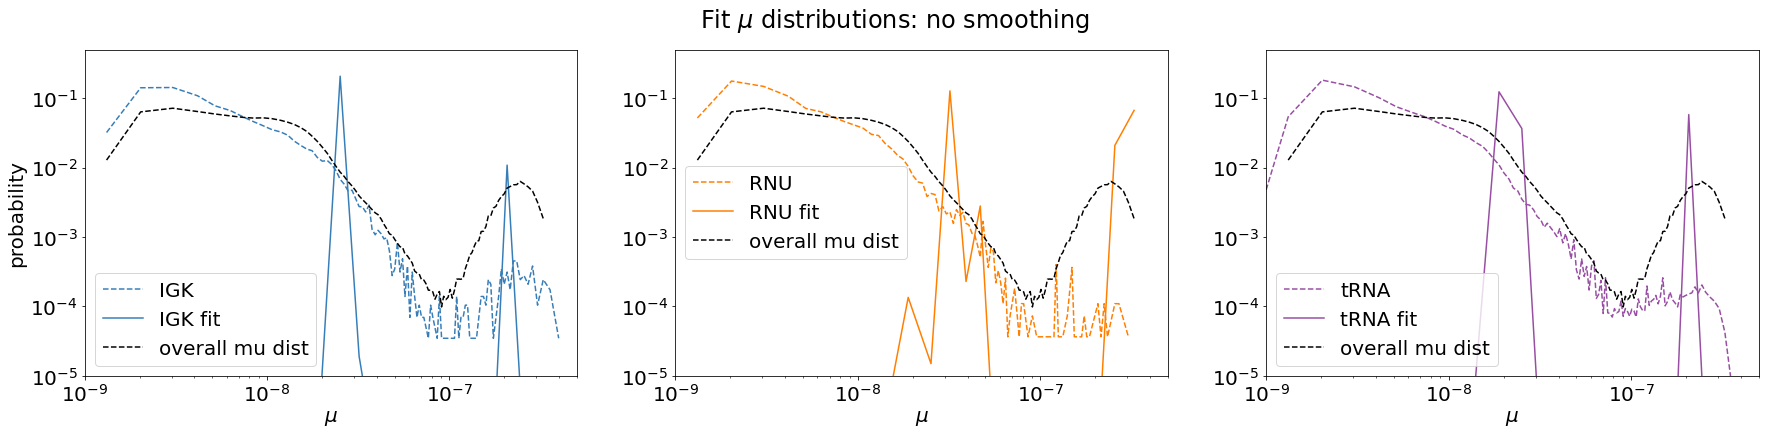

In [921]:
fig, axes = plt.subplots(1,3,figsize=(30,6))

def nm(x):
    return x/np.sum(x)

RNU_mu, RNU_mu_counts = np.unique(gene_type_mu["RNU"], return_counts=True)
tRNA_mu, tRNA_mu_counts = np.unique(gene_type_mu["tRNA"], return_counts=True)
IGK_mu, IGK_mu_counts = np.unique(gene_type_mu["IGK"], return_counts=True)

axes[0].plot(IGK_mu*MU_SCALE, IGK_mu_counts / np.sum(IGK_mu_counts), "--", label="IGK", c="#377eb8")
axes[1].plot(RNU_mu*MU_SCALE, RNU_mu_counts / np.sum(RNU_mu_counts), "--", label="RNU", c="#ff7f00")
axes[2].plot(tRNA_mu*MU_SCALE, tRNA_mu_counts / np.sum(tRNA_mu_counts), "--", label="tRNA", c="#984ea3")

axes[0].plot(mu_vals_small*MU_SCALE, small_rescale * softmax_trans(fit_IGK_nosmooth['x']), label="IGK fit", c="#377eb8")
axes[1].plot(mu_vals_small*MU_SCALE, small_rescale * softmax_trans(fit_RNU_nosmooth['x']), label="RNU fit", c="#ff7f00")
axes[2].plot(mu_vals_small*MU_SCALE, small_rescale * softmax_trans(fit_tRNA_nosmooth['x']), label="tRNA fit",c="#984ea3")

axes[0].set_ylabel("probability")

for i in range(3):
    axes[i].plot(mu_vals_fit*MU_SCALE, overall_dist, "--", c="black", label="overall mu dist")
    axes[i].set_yscale("symlog", linthresh=1e-5)
    axes[i].set_xscale("log")
    axes[i].set_ylim((1e-5,0.5))
    axes[i].legend()
    axes[i].set_xlabel(r"$\mu$")
    axes[i].set_xlim((1e-9, 5e-7))
    
fig.suptitle(r'Fit $\mu$ distributions: no smoothing')
fig.savefig('IGK_mu_fit_no_smoothing.pdf', bbox_inches='tight')

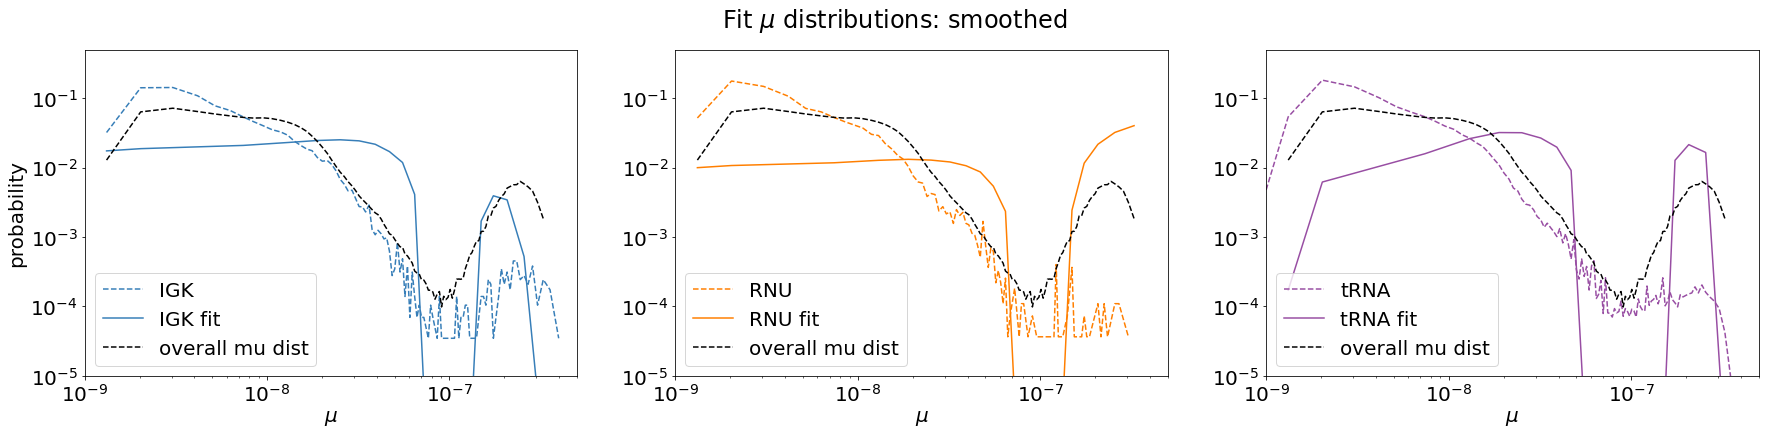

In [923]:
fig, axes = plt.subplots(1,3,figsize=(30,6))

axes[0].plot(IGK_mu*MU_SCALE, IGK_mu_counts / np.sum(IGK_mu_counts), "--", label="IGK", c="#377eb8")
axes[1].plot(RNU_mu*MU_SCALE, RNU_mu_counts / np.sum(RNU_mu_counts), "--", label="RNU", c="#ff7f00")
axes[2].plot(tRNA_mu*MU_SCALE, tRNA_mu_counts / np.sum(tRNA_mu_counts), "--", label="tRNA", c="#984ea3")

axes[0].plot(mu_vals_small*MU_SCALE, small_rescale * softmax_trans(fit_IGK['x']), label="IGK fit", c="#377eb8")
axes[1].plot(mu_vals_small*MU_SCALE, small_rescale * softmax_trans(fit_RNU['x']), label="RNU fit", c="#ff7f00")
axes[2].plot(mu_vals_small*MU_SCALE, small_rescale * softmax_trans(fit_tRNA['x']), label="tRNA fit",c="#984ea3")

axes[0].set_ylabel("probability")

for i in range(3):
    axes[i].plot(mu_vals_fit*MU_SCALE, overall_dist, "--", c="black", label="overall mu dist")
    axes[i].set_yscale("symlog", linthresh=1e-5)
    axes[i].set_xscale("log")
    axes[i].set_ylim((1e-5,0.5))
    axes[i].legend()
    axes[i].set_xlabel(r"$\mu$")
    axes[i].set_xlim((1e-9, 5e-7))
    
fig.suptitle(r'Fit $\mu$ distributions: smoothed')
fig.savefig('IGK_mu_fit_smoothed.pdf', bbox_inches='tight')

Now combine SFS fits with earlier analyses of de novo mutations.

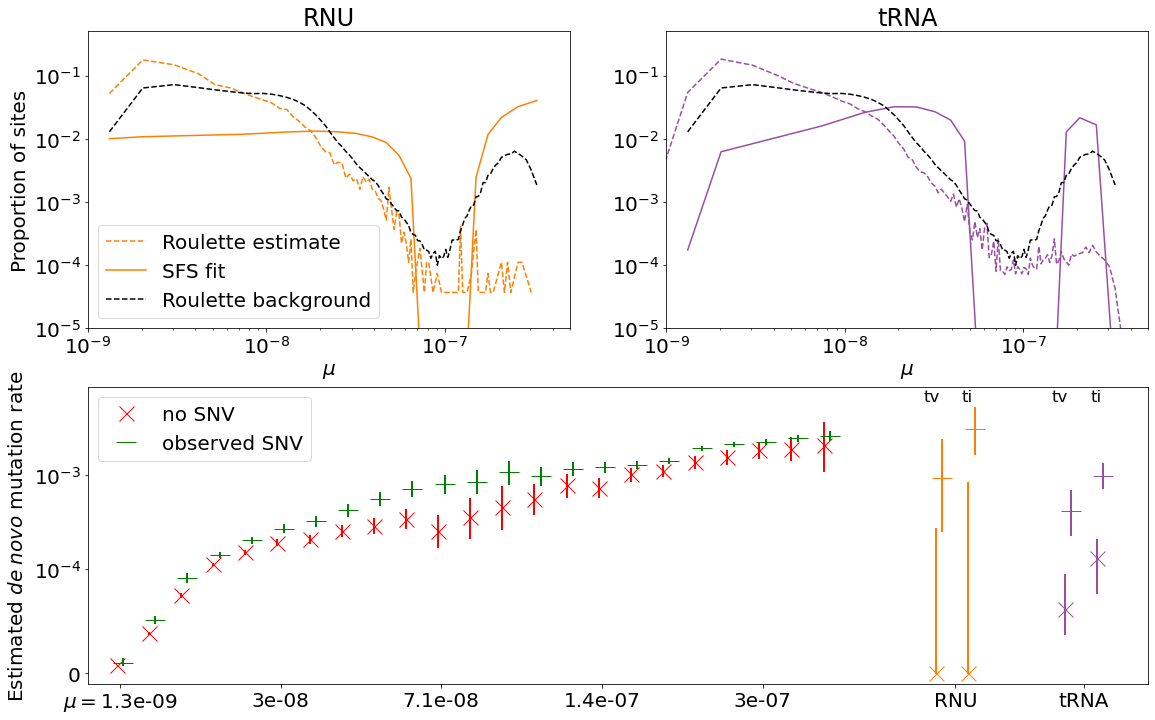

In [928]:
fig, _ = plt.subplots(2, 2, figsize=(19, 12))
plt.subplot(2, 2, 1)
plt.plot(RNU_mu*MU_SCALE, RNU_mu_counts / np.sum(RNU_mu_counts), "--", label="Roulette estimate", c=RNU_C)
plt.plot(mu_vals_small*MU_SCALE, small_rescale * softmax_trans(fit_RNU['x']), label="SFS fit", c=RNU_C)
plt.plot(mu_vals_fit*MU_SCALE, overall_dist, "--", c="black", label="Roulette background")
plt.yscale("symlog", linthresh=1e-5)
plt.xscale("log")
plt.ylim((1e-5,0.5))
plt.xlim((1e-9, 5e-7))
plt.legend()
plt.xlabel(r"$\mu$")
plt.ylabel("Proportion of sites")
plt.title("RNU")
plt.subplot(2, 2, 2)
plt.plot(tRNA_mu*MU_SCALE, tRNA_mu_counts / np.sum(tRNA_mu_counts), "--", c=tRNA_C)
plt.plot(mu_vals_small*MU_SCALE, small_rescale * softmax_trans(fit_tRNA['x']), c=tRNA_C)
plt.plot(mu_vals_fit*MU_SCALE, overall_dist, "--", c="black")
plt.yscale("symlog", linthresh=1e-5)
plt.xscale("log")
plt.ylim((1e-5,0.5))
plt.xlim((1e-9, 5e-7))
plt.xlabel(r"$\mu$")
plt.title("tRNA")
plt.subplot(2, 1, 2)
gap_size = 0.1

max_rate = np.max(denovo_roulette.predicted_rate)
min_rate = np.min(denovo_roulette.predicted_rate)
# compare_inds = np.concatenate((np.arange(0, len(denovo_roulette.predicted_rate)-10, 4), 
#                                np.arange(len(denovo_roulette.predicted_rate)-10, len(denovo_roulette.predicted_rate)-1)))

compare_inds = np.concatenate((np.arange(0, len(denovo_roulette.predicted_rate)-10, 5), 
                               np.arange(len(denovo_roulette.predicted_rate)-6, len(denovo_roulette.predicted_rate)-1)))

n_compare = len(compare_inds)
plot_inds = np.arange(n_compare)

no_ms = 15
ms = 20
lw = 2
osize = 4

plt.plot(plot_inds-gap_size, denovo_roulette.mu_mono_est[compare_inds], "x", markersize=no_ms, color="red", label="no SNV")
#plt.plot(plot_inds-gap_size, denovo_roulette.mu_mono_est[compare_inds], "o", markersize=osize, color="red")

plt.plot([plot_inds-gap_size]*2, [denovo_roulette.mu_mono_95CI_lower[compare_inds], 
                        denovo_roulette.mu_mono_95CI_upper[compare_inds]], color="red", linewidth=lw)

plt.plot(plot_inds+gap_size, denovo_roulette.mu_poly_est[compare_inds], "_", markersize=ms, color="green", label="observed SNV")
#plt.plot(plot_inds+gap_size, denovo_roulette.mu_poly_est[compare_inds], "o", markersize=osize, color="green")

plt.plot([plot_inds+gap_size]*2, [denovo_roulette.mu_poly_95CI_lower[compare_inds], 
                        denovo_roulette.mu_poly_95CI_upper[compare_inds]], color="green", linewidth=lw)



RNU_x_tv = n_compare + 2.5
RNU_x_ti = n_compare + 3.5

plt.plot(RNU_x_tv-gap_size, denovo_ti_table.xs("RNU", level="gene_class").xs(False, level="ti").est_denovo_rate[0], "x", color=RNU_C, markersize=no_ms)
#plt.plot(RNU_x_tv-gap_size, denovo_ti_table.xs("RNU", level="gene_class").xs(False, level="ti").est_denovo_rate[0], "o", color=RNU_C, markersize=osize)

plt.plot([RNU_x_tv-gap_size]*2, [denovo_ti_table.xs("RNU", level="gene_class").xs(False, level="ti").est_denovo_lower[0],
                 denovo_ti_table.xs("RNU", level="gene_class").xs(False, level="ti").est_denovo_upper[0]], color=RNU_C, linewidth=lw)
plt.plot(RNU_x_tv+gap_size, denovo_ti_table.xs("RNU", level="gene_class").xs(False, level="ti").est_denovo_rate[1], "_", color=RNU_C, markersize=ms)
plt.plot([RNU_x_tv+gap_size]*2, [denovo_ti_table.xs("RNU", level="gene_class").xs(False, level="ti").est_denovo_lower[1],
                 denovo_ti_table.xs("RNU", level="gene_class").xs(False, level="ti").est_denovo_upper[1]], color=RNU_C, linewidth=lw)

plt.plot(RNU_x_ti-gap_size, denovo_ti_table.xs("RNU", level="gene_class").xs(True, level="ti").est_denovo_rate[0], "x", color=RNU_C, markersize=no_ms)
plt.plot([RNU_x_ti-gap_size]*2, [denovo_ti_table.xs("RNU", level="gene_class").xs(True, level="ti").est_denovo_lower[0],
                 denovo_ti_table.xs("RNU", level="gene_class").xs(True, level="ti").est_denovo_upper[0]], color=RNU_C, linewidth=lw)
plt.plot(RNU_x_ti+gap_size, denovo_ti_table.xs("RNU", level="gene_class").xs(True, level="ti").est_denovo_rate[1], "_", color=RNU_C, markersize=ms)
plt.plot([RNU_x_ti+gap_size]*2, [denovo_ti_table.xs("RNU", level="gene_class").xs(True, level="ti").est_denovo_lower[1],
                 denovo_ti_table.xs("RNU", level="gene_class").xs(True, level="ti").est_denovo_upper[1]], color=RNU_C, linewidth=lw)

tRNA_x_tv = n_compare + 6.5
tRNA_x_ti = n_compare + 7.5

plt.plot(tRNA_x_tv-gap_size, denovo_ti_table.xs("tRNA", level="gene_class").xs(False, level="ti").est_denovo_rate[0], "x", color=tRNA_C, markersize=no_ms)
plt.plot([tRNA_x_tv-gap_size]*2, [denovo_ti_table.xs("tRNA", level="gene_class").xs(False, level="ti").est_denovo_lower[0],
                 denovo_ti_table.xs("tRNA", level="gene_class").xs(False, level="ti").est_denovo_upper[0]], color=tRNA_C, linewidth=lw)
plt.plot(tRNA_x_tv+gap_size, denovo_ti_table.xs("tRNA", level="gene_class").xs(False, level="ti").est_denovo_rate[1], "_", color=tRNA_C, markersize=ms)
plt.plot([tRNA_x_tv+gap_size]*2, [denovo_ti_table.xs("tRNA", level="gene_class").xs(False, level="ti").est_denovo_lower[1],
                 denovo_ti_table.xs("tRNA", level="gene_class").xs(False, level="ti").est_denovo_upper[1]], color=tRNA_C, linewidth=lw)


plt.plot(tRNA_x_ti-gap_size, denovo_ti_table.xs("tRNA", level="gene_class").xs(True, level="ti").est_denovo_rate[0], "x", color=tRNA_C, markersize=no_ms)
plt.plot([tRNA_x_ti-gap_size]*2, [denovo_ti_table.xs("tRNA", level="gene_class").xs(True, level="ti").est_denovo_lower[0],
                 denovo_ti_table.xs("tRNA", level="gene_class").xs(True, level="ti").est_denovo_upper[0]], color=tRNA_C, linewidth=lw)
plt.plot(tRNA_x_ti+gap_size, denovo_ti_table.xs("tRNA", level="gene_class").xs(True, level="ti").est_denovo_rate[1], "_", color=tRNA_C, markersize=ms)
plt.plot([tRNA_x_ti+gap_size]*2, [denovo_ti_table.xs("tRNA", level="gene_class").xs(True, level="ti").est_denovo_lower[1],
                 denovo_ti_table.xs("tRNA", level="gene_class").xs(True, level="ti").est_denovo_upper[1]], color=tRNA_C, linewidth=lw)

fontsize="small"
plt.text(n_compare + 2, 0.006, "tv", fontsize=fontsize)
plt.text(n_compare + 3.2, 0.006, "ti", fontsize=fontsize)

plt.text(n_compare + 6, 0.006, "tv", fontsize=fontsize)
plt.text(n_compare + 7.2, 0.006, "ti", fontsize=fontsize)

plt.yscale("symlog", linthresh=1e-4)

plt.xlim([-1, n_compare + 9])
plt.ylim([-1e-5, 0.0085])
plt.ylabel(r"Estimated $\it{de {}_ novo}$ mutation rate")

x_ticklabels = np.concatenate((round_sig(1e-7*denovo_roulette.predicted_rate[compare_inds[::5]], 2), ["RNU", "tRNA"]))
x_ticklabels[0] = r"$\mu=$"+x_ticklabels[0]

plt.xticks(np.concatenate((plot_inds[::5], [n_compare + 3, n_compare + 7])), 
           labels=x_ticklabels);
plt.legend()

fig.savefig("RNU_tRNA_mu_distribution.pdf", bbox_inches="tight")

In [936]:
poly_norm(gene_type_sfs_binned[2]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[2]))

array([5.72573976e-01, 2.06640788e-01, 1.11571433e-01, 6.88802627e-02,
       3.22861678e-02, 6.84093662e-03, 9.84628001e-04, 1.74310300e-04,
       3.60630986e-05, 8.76289641e-06, 1.97333755e-06, 4.69673265e-07,
       1.19488664e-07, 7.35081758e-08, 3.54835701e-08])

As a sanity check, see how well the different models actually capture the shape of the SFS.

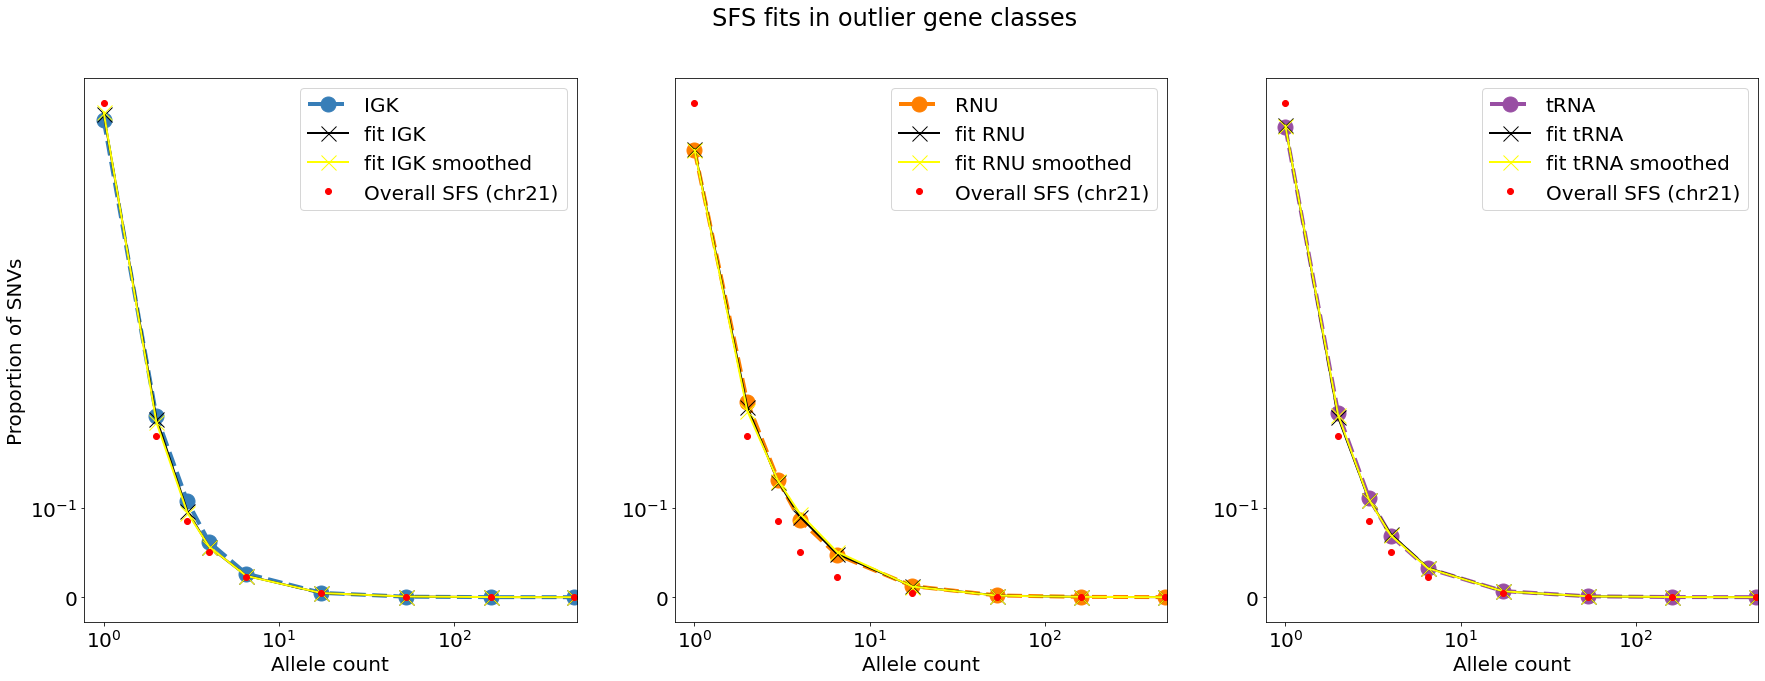

In [944]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))

overall_sfs = nm(np.matmul(mu_21_norm, overall_dist) / sfs_bin_sizes[1:])
                         
axes[0].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[0]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[0])), 
        "o--", c="#377eb8", linewidth=4, markersize=15, label="IGK")
axes[1].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[1]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[1])), 
        "o--", c="#ff7f00", linewidth=4, markersize=15, label="RNU")
axes[2].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[2]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[2])), 
        "o--", c="#984ea3", linewidth=4, markersize=15, label="tRNA")

fit_IGK_sfs = np.matmul(mu_21_norm_small, softmax_trans(fit_IGK_nosmooth['x'])) / sfs_bin_sizes[1:]
fit_IGK_reg_sfs = np.matmul(mu_21_norm_small, softmax_trans(fit_IGK['x'])) / sfs_bin_sizes[1:]
axes[0].plot(sfs_bin_means[1:], nm(fit_IGK_sfs) , "x-", label="fit IGK", color="black", linewidth=2, markersize=15)
axes[0].plot(sfs_bin_means[1:], nm(fit_IGK_reg_sfs) , "x-", label="fit IGK smoothed", color="yellow", linewidth=2, markersize=15)

fit_RNU_sfs = np.matmul(mu_21_norm_small, softmax_trans(fit_RNU_nosmooth['x'])) / sfs_bin_sizes[1:]
fit_RNU_reg_sfs = np.matmul(mu_21_norm_small, softmax_trans(fit_RNU['x'])) / sfs_bin_sizes[1:]
axes[1].plot(sfs_bin_means[1:], nm(fit_RNU_sfs) , "x-", label="fit RNU", color="black", linewidth=2, markersize=15)
axes[1].plot(sfs_bin_means[1:], nm(fit_RNU_reg_sfs) , "x-", label="fit RNU smoothed", color="yellow", linewidth=2, markersize=15)

fit_tRNA_sfs = np.matmul(mu_21_norm_small, softmax_trans(fit_tRNA_nosmooth['x'])) / sfs_bin_sizes[1:]
fit_tRNA_reg_sfs = np.matmul(mu_21_norm_small, softmax_trans(fit_tRNA['x'])) / sfs_bin_sizes[1:]
axes[2].plot(sfs_bin_means[1:], nm(fit_tRNA_sfs) , "x-", label="fit tRNA", color="black", linewidth=2, markersize=15)
axes[2].plot(sfs_bin_means[1:], nm(fit_tRNA_reg_sfs) , "x-", label="fit tRNA smoothed", color="yellow", linewidth=2, markersize=15)

for ii in range(3):
    axes[ii].plot(sfs_bin_means[1:], overall_sfs, "o", c="red", label="Overall SFS (chr21)")
    axes[ii].set_yscale("symlog", linthresh=0.5)
    axes[ii].set_xscale("symlog", linthresh=1)
    axes[ii].legend()
    axes[ii].set_xlim(0.9, 5e2)
    axes[ii].set_xlabel("Allele count")

axes[0].set_ylabel("Proportion of SNVs")

fig.suptitle(r'SFS fits in outlier gene classes')
fig.savefig('SFS_fits_low_count.pdf', bbox_inches='tight')

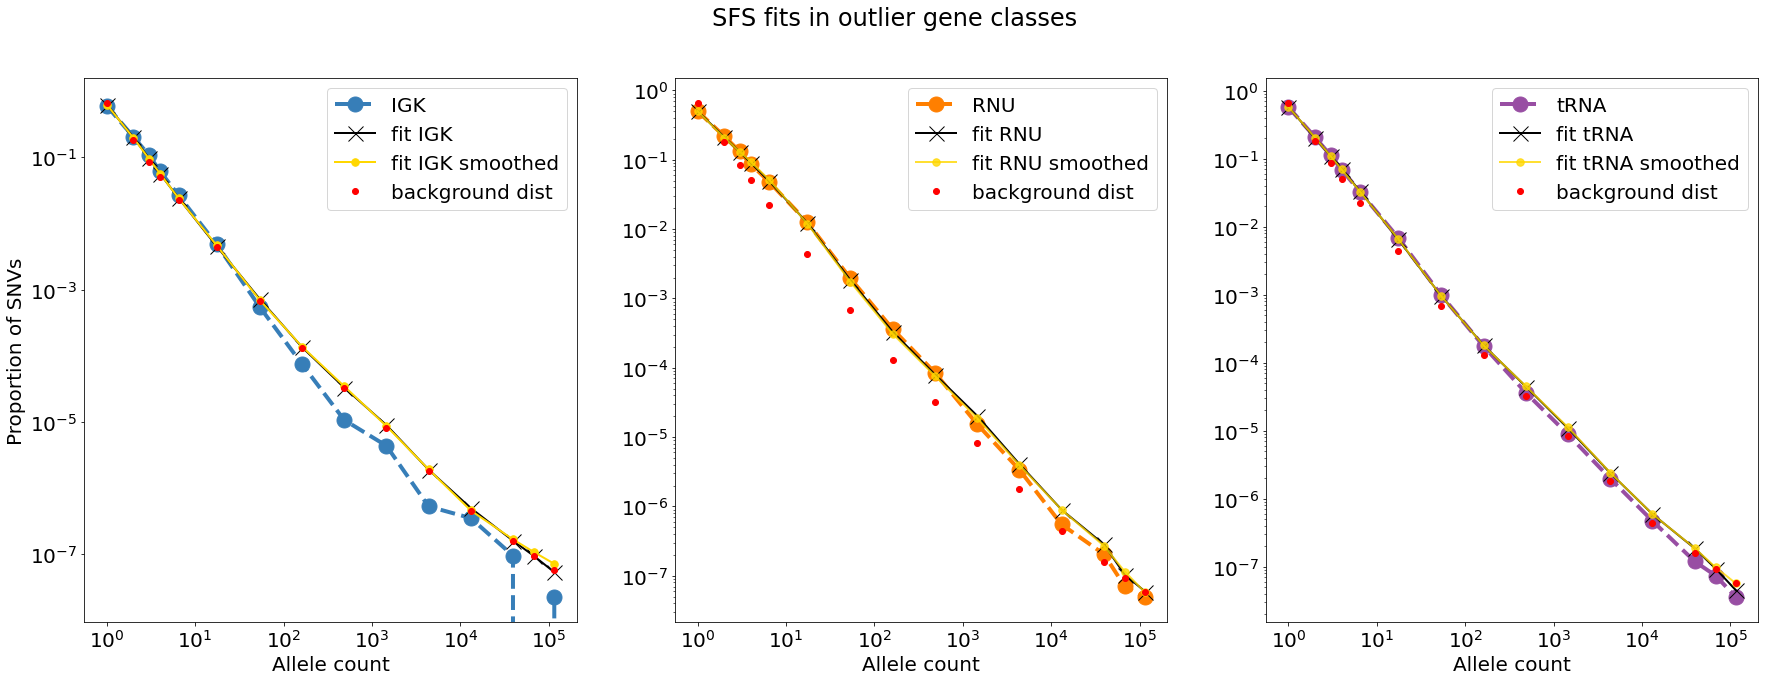

In [946]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))

overall_sfs = nm(np.matmul(mu_21_norm, overall_dist) / sfs_bin_sizes[1:])
                         
axes[0].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[0]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[0])), 
        "o--", c="#377eb8", linewidth=4, markersize=15, label="IGK")
axes[1].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[1]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[1])), 
        "o--", c="#ff7f00", linewidth=4, markersize=15, label="RNU")
axes[2].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[2]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[2])), 
        "o--", c="#984ea3", linewidth=4, markersize=15, label="tRNA")

axes[0].plot(sfs_bin_means[1:], nm(fit_IGK_sfs) , "x-", label="fit IGK", color="black", linewidth=2, markersize=15)
axes[0].plot(sfs_bin_means[1:], nm(fit_IGK_reg_sfs) , ".-", label="fit IGK smoothed", color="gold", linewidth=2, markersize=15)

axes[1].plot(sfs_bin_means[1:], nm(fit_RNU_sfs) , "x-", label="fit RNU", color="black", linewidth=2, markersize=15)
axes[1].plot(sfs_bin_means[1:], nm(fit_RNU_reg_sfs) , ".-", label="fit RNU smoothed", color="gold", linewidth=2, markersize=15, alpha=0.8)

axes[2].plot(sfs_bin_means[1:], nm(fit_tRNA_sfs) , "x-", label="fit tRNA", color="black", linewidth=2, markersize=15,alpha=1)
axes[2].plot(sfs_bin_means[1:], nm(fit_tRNA_reg_sfs) , ".-", label="fit tRNA smoothed", color="gold", linewidth=2, markersize=15, alpha=0.8)

for ii in range(3):
    axes[ii].plot(sfs_bin_means[1:], overall_sfs, "o", c="red", label="background dist")
    axes[ii].set_xscale("symlog", linthresh=1)
    axes[ii].legend()
    axes[ii].set_xlabel("Allele count")
    axes[ii].set_yscale("Log")

axes[0].set_ylabel("Proportion of SNVs")

fig.suptitle(r'SFS fits in outlier gene classes')
fig.savefig('SFS_fits_high_counts.pdf', bbox_inches='tight')

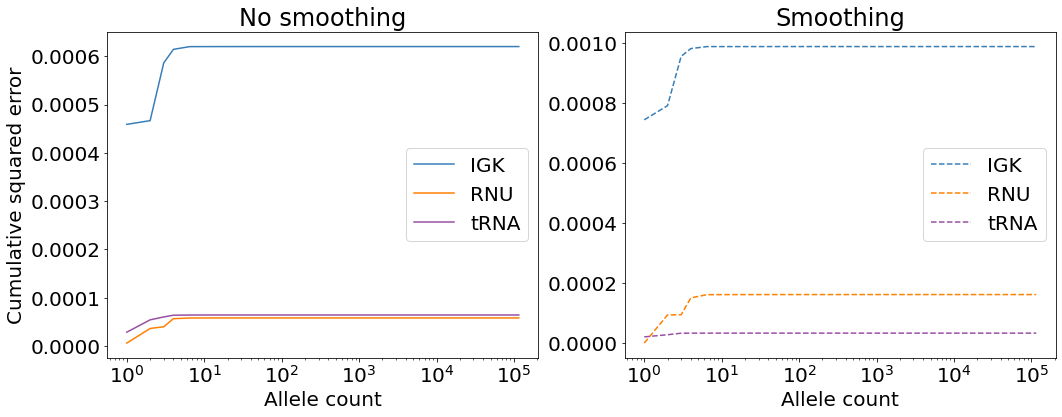

In [949]:
fig, axes = plt.subplots(1, 2, figsize=(17,6))
axes[0].plot(sfs_bin_means[1:], np.cumsum(np.abs(nm(fit_IGK_sfs) -  poly_norm(gene_type_sfs_binned[0]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[0])))**2), label="IGK", c=IGK_C)
axes[0].plot(sfs_bin_means[1:], np.cumsum(np.abs(nm(fit_RNU_sfs) -  poly_norm(gene_type_sfs_binned[1]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[1])))**2), label="RNU", c=RNU_C)
axes[0].plot(sfs_bin_means[1:], np.cumsum(np.abs(nm(fit_tRNA_sfs) -  poly_norm(gene_type_sfs_binned[2]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[2])))**2), label="tRNA", c=tRNA_C)

axes[1].plot(sfs_bin_means[1:], np.cumsum(np.abs(nm(fit_IGK_reg_sfs) -  poly_norm(gene_type_sfs_binned[0]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[0])))**2), "--", label="IGK", c=IGK_C)
axes[1].plot(sfs_bin_means[1:], np.cumsum(np.abs(nm(fit_RNU_reg_sfs) -  poly_norm(gene_type_sfs_binned[1]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[1])))**2), "--", label="RNU", c=RNU_C)
axes[1].plot(sfs_bin_means[1:], np.cumsum(np.abs(nm(fit_tRNA_reg_sfs) -  poly_norm(gene_type_sfs_binned[2]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[2])))**2), "--", label="tRNA", c=tRNA_C)

axes[0].set_ylabel("Cumulative squared error")
axes[0].set_title("No smoothing")
axes[1].set_title("Smoothing")
for ax in axes:
    ax.legend()
    ax.set_xscale("log")
    ax.set_xlabel("Allele count")
fig.savefig("cumulative_error.pdf", bbox_inches="tight")

As another check, sample values with matched Roulette mutation rates to genes in our three classes at random from chromosome 21.

In [953]:
RNU_match_samp = sample_mu(data_21, gene_type_mu["RNU"], 100)

In [954]:
RNU_match_sfs = [ac_df(data_samp, name="samp_"+str(ii)) for ii, data_samp in enumerate(RNU_match_samp)]
RNU_match_binned = [rr.bin_data(nonzero(sfs).ac, nonzero(sfs).nn, sfs_bins) for sfs in RNU_match_sfs]

In [955]:
tRNA_match_samp = sample_mu(data_21, gene_type_mu["tRNA"], 10)

In [956]:
tRNA_match_sfs = [ac_df(data_samp, name="samp_"+str(ii)) for ii, data_samp in enumerate(tRNA_match_samp)]
tRNA_match_binned = [rr.bin_data(nonzero(sfs).ac, nonzero(sfs).nn, sfs_bins) for sfs in tRNA_match_sfs]

In [957]:
IGK_match_samp = sample_mu(data_21, gene_type_mu["IGK"], 100)

In [958]:
IGK_match_sfs = [ac_df(data_samp, name="samp_"+str(ii)) for ii, data_samp in enumerate(IGK_match_samp)]
IGK_match_binned = [rr.bin_data(nonzero(sfs).ac, nonzero(sfs).nn, sfs_bins) for sfs in IGK_match_sfs]

Text(0.5, 0, 'Allele count')

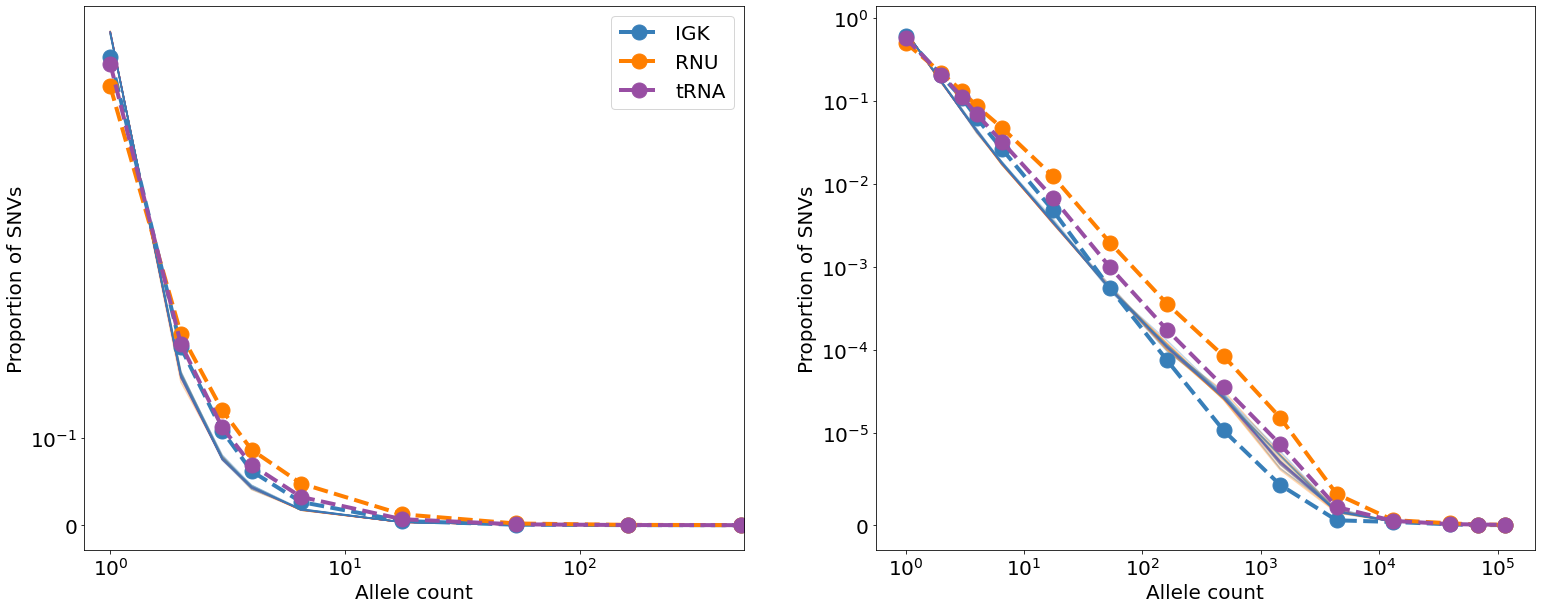

In [961]:
fig, axes = plt.subplots(1, 2, figsize=(26,10))

for ii, RNU_match in enumerate(RNU_match_binned[:10]):
    sfs_tmp = RNU_match/sfs_bin_sizes
    axes[0].plot(sfs_bin_means[1:], poly_norm(sfs_tmp), c="#ff7f00", alpha=0.3)
    axes[1].plot(sfs_bin_means[1:], poly_norm(sfs_tmp), c="#ff7f00", alpha=0.3)
    
for ii, tRNA_match in enumerate(tRNA_match_binned):
    sfs_tmp = tRNA_match/sfs_bin_sizes
    axes[0].plot(sfs_bin_means[1:], poly_norm(sfs_tmp), c="#984ea3", alpha=0.3)
    axes[1].plot(sfs_bin_means[1:], poly_norm(sfs_tmp), c="#984ea3", alpha=0.3)
    
for ii, IGK_match in enumerate(IGK_match_binned[:10]):
    sfs_tmp = IGK_match/sfs_bin_sizes
    axes[0].plot(sfs_bin_means[1:], poly_norm(sfs_tmp), c="#377eb8", alpha=0.3)
    axes[1].plot(sfs_bin_means[1:], poly_norm(sfs_tmp), c="#377eb8", alpha=0.3)

axes[0].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[0]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[0])), 
        "o--", c="#377eb8", linewidth=4, markersize=15, label="IGK")
axes[0].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[1]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[1])), 
        "o--", c="#ff7f00", linewidth=4, markersize=15, label="RNU")
axes[0].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[2]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[2])), 
        "o--", c="#984ea3", linewidth=4, markersize=15, label="tRNA")

axes[1].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[0]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[0])), 
        "o--", c="#377eb8", linewidth=4, markersize=15, label="IGK")
axes[1].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[1]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[1])), 
        "o--", c="#ff7f00", linewidth=4, markersize=15, label="RNU")
axes[1].plot(sfs_bin_means[1:], poly_norm(gene_type_sfs_binned[2]/sfs_bin_sizes/np.sum(gene_type_sfs_binned[2])), 
        "o--", c="#984ea3", linewidth=4, markersize=15, label="tRNA")
    
axes[0].set_yscale("symlog", linthresh=0.5)
axes[0].set_xscale("symlog", linthresh=1)
axes[0].legend()

axes[1].set_yscale("symlog", linthresh=1e-5)
axes[1].set_xscale("symlog", linthresh=1)

axes[0].set_xlim(0.9, 5e2)

axes[0].set_ylabel("Proportion of SNVs")
axes[0].set_xlabel("Allele count")

axes[1].set_ylabel("Proportion of SNVs")
axes[1].set_xlabel("Allele count")

There are strong deviations here for each class.

Finally, we will examine some quality metrics for the three gene classes by comparing metrics for polymorphisms in these genes to the background distribution from chromosome 21.

In [962]:
colnames = ["CHR", "POS", "REF", "ALT", "FILTER", "AC", "AN", "MQRankSum", "pab_max", "VQSLOD", "AB", "PN", "MR", "AR", "MG", "MC", "QUAL"]

In [978]:
# Data from the 1kg subset of gnomAD for chromosome 21
indiv_1kg_21 = pd.read_csv(os.path.join(data_dir, "21_indiv_mu_all.csv.gz"), sep=" ", names=colnames)

/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (5,6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [979]:
indiv_1kg_21.head()

,CHR,POS,REF,ALT,FILTER,AC,AN,MQRankSum,pab_max,VQSLOD,AB,PN,MR,AR,MG,MC,QUAL
0,chr21,5030082,G,A,AC0;AS_VQSR,0,2,.,.,-15.2842,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0,.,.,.,.,.,.
1,chr21,5030088,C,T,AC0;AS_VQSR,0,2,0.727,1,-13.5163,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0,.,.,.,.,.,.
2,chr21,5030105,C,A,AC0;AS_VQSR,0,2,0,1,-11.5268,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0,.,.,.,.,.,.
3,chr21,5030240,AC,A,PASS,19,1228,0.322,1,12.3863,0|0|0|0|0|0|2|1|2|1|5|0|1|2|0|0|0|0|0|0,.,.,.,.,.,.
4,chr21,5030253,G,T,AS_VQSR,1,1578,-0.937,1,-3.6576,0|0|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0,TGGAT,0.094,.,0.045,.,low


In [980]:
indiv_1kg_21 = indiv_1kg_21.loc[indiv_1kg_21.AC!="."]
indiv_1kg_21 = indiv_1kg_21.loc[(indiv_1kg_21.AC.to_numpy(dtype=int)>0) & 
                                (indiv_1kg_21.MR!=".") &
                                (indiv_1kg_21.QUAL!="low") & 
                                (indiv_1kg_21.QUAL!="SFS_bump") & 
                                (indiv_1kg_21.FILTER=="PASS") & 
                                (indiv_1kg_21.MQRankSum!=".") & 
                                (indiv_1kg_21.pab_max!=".") &
                                (vlen(indiv_1kg_21.REF)==1) & 
                                (vlen(indiv_1kg_21.ALT)==1)]

In [981]:
indiv_1kg_21.AC = indiv_1kg_21.AC.to_numpy(dtype=int)

In [967]:
# gnomAD 1kg data subset to 
data_1kg = pd.concat([pd.read_csv(os.path.join(data_dir, str(ii)+"_indiv_mu.csv"), header=None, sep=" ",
                           names=["CHR", "POS", "REF", "ALT", "FILTER", "AC", "AN", "MQRankSum", "pab_max", "VQSLOD", "AB", "PN", "MR", "AR", "MG", "MC", "QUAL"]) for ii in range(1, 23)])

data_1kg = data_1kg.loc[(data_1kg.AC>0) &
                        (data_1kg.MR!=".") &
                        (data_1kg.QUAL!="low") & 
                        (data_1kg.QUAL!="SFS_bump") & 
                        (data_1kg.FILTER=="PASS") & 
                        (data_1kg.MQRankSum!=".") & 
                        (data_1kg.pab_max!=".")]

In [984]:
data_1kg.head()

,CHR,POS,REF,ALT,FILTER,AC,AN,MQRankSum,pab_max,VQSLOD,AB,PN,MR,AR,MG,MC,QUAL
0,chr1,4566910,G,A,PASS,1,6760,1.043,1,5.2078,0|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0,TGGGG,0.198,.,0.147,.,TFBS
1,chr1,4566920,G,C,PASS,1,6756,-0.306,1,5.2724,0|0|0|0|0|0|0|0|0|2|0|2|1|0|0|0|0|0|0|0,GGGCT,0.051,.,0.042,.,TFBS
2,chr1,4566922,T,G,PASS,1,6760,-0.232,1,5.0547,0|0|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0,GCTTG,0.030,.,0.025,.,TFBS
3,chr1,4566937,G,A,PASS,1,6760,0.234,1,4.3937,0|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0,AAGAG,0.236,.,0.096,.,TFBS
4,chr1,4566950,T,A,PASS,6,6760,-0.222,1,4.0222,0|0|0|0|0|0|0|1|2|3|2|2|3|0|0|0|1|0|0|0,ACTGG,0.030,.,0.019,.,TFBS


In [969]:
RNU_sites = [pos in RNU_positions for pos in data_1kg.POS]
tRNA_sites = [pos in tRNA_positions for pos in data_1kg.POS]
IGK_sites = [pos in IGK_positions for pos in data_1kg.POS]

In [970]:
def AB_summarize(ab_set):
    result = None
    for ab in ab_set:
        if result is None:
            result = np.array(ab.split("|"), dtype=np.int)
        else:
            result += np.array(ab.split("|"), dtype=np.int)
    return result

In [971]:
indiv_1kg_21_ab = AB_summarize(indiv_1kg_21.loc[indiv_1kg_21.AB!="."].AB.to_numpy())

In [973]:
data_1kg_RNU = data_1kg.loc[RNU_sites]
data_1kg_tRNA = data_1kg.loc[tRNA_sites]
data_1kg_IGK = data_1kg.loc[IGK_sites]

Examine the distribution of alleleic balances for singletons.

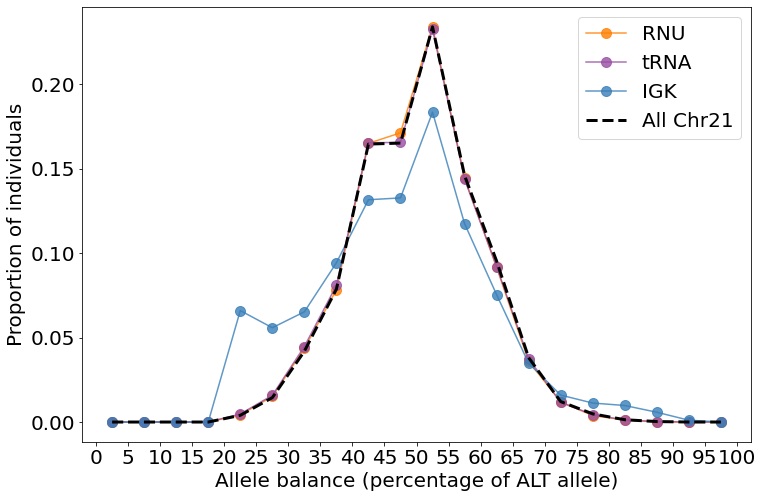

In [975]:
fig,ax = plt.subplots(figsize=(12,8))
full_ab = AB_summarize(data_1kg.loc[RNU_sites & (data_1kg.AB!=".") & (data_1kg.AC==1)].AB.to_numpy())
plt.plot(full_ab/np.sum(full_ab), "-o", label="RNU", alpha=0.8, color=RNU_C, markersize=10)
full_ab = AB_summarize(data_1kg.loc[tRNA_sites & (data_1kg.AB!=".") & (data_1kg.AC==1)].AB.to_numpy())
plt.plot(full_ab/np.sum(full_ab), "-o", label="tRNA", alpha=0.8, color=tRNA_C, markersize=10)
full_ab = AB_summarize(data_1kg.loc[IGK_sites & (data_1kg.AB!=".") & (data_1kg.AC==1)].AB.to_numpy())
plt.plot(full_ab/np.sum(full_ab), "-o", label="IGK", alpha=0.8, color=IGK_C, markersize=10)

plt.plot(indiv_1kg_21_ab/np.sum(indiv_1kg_21_ab), "--", label="All Chr21", color="black", linewidth=3)

plt.xticks(np.arange(0,21,1)-0.5)
ax.set_xticklabels(np.arange(0,21,1)*5)
plt.xlabel("Allele balance (percentage of ALT allele)")
plt.ylabel("Proportion of individuals")
plt.legend()
fig.savefig("ab_plot.pdf", bbox_inches="tight")

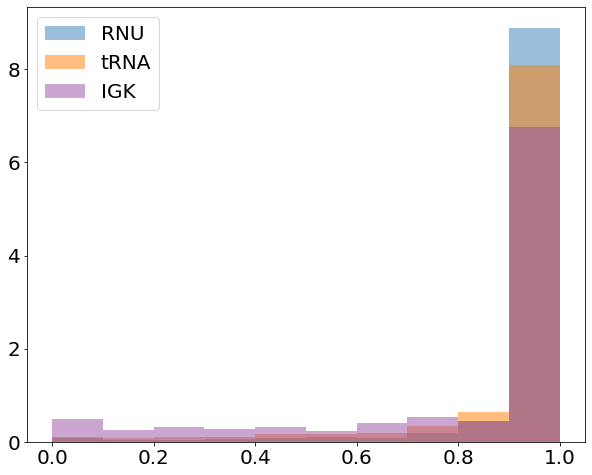

In [759]:
fig,axes = plt.subplots(1, 1, figsize=(10,8))
axes.hist(data_1kg_RNU.pab_max.to_numpy(dtype=float), alpha=0.5, density=True, label="RNU");
axes.hist(data_1kg_tRNA.pab_max.to_numpy(dtype=float), alpha=0.5, density=True, label="tRNA");
axes.hist(data_1kg_IGK.pab_max.to_numpy(dtype=float), alpha=0.5, density=True, label="IGK");
plt.legend()

Next check the distributions of mapping quality. 

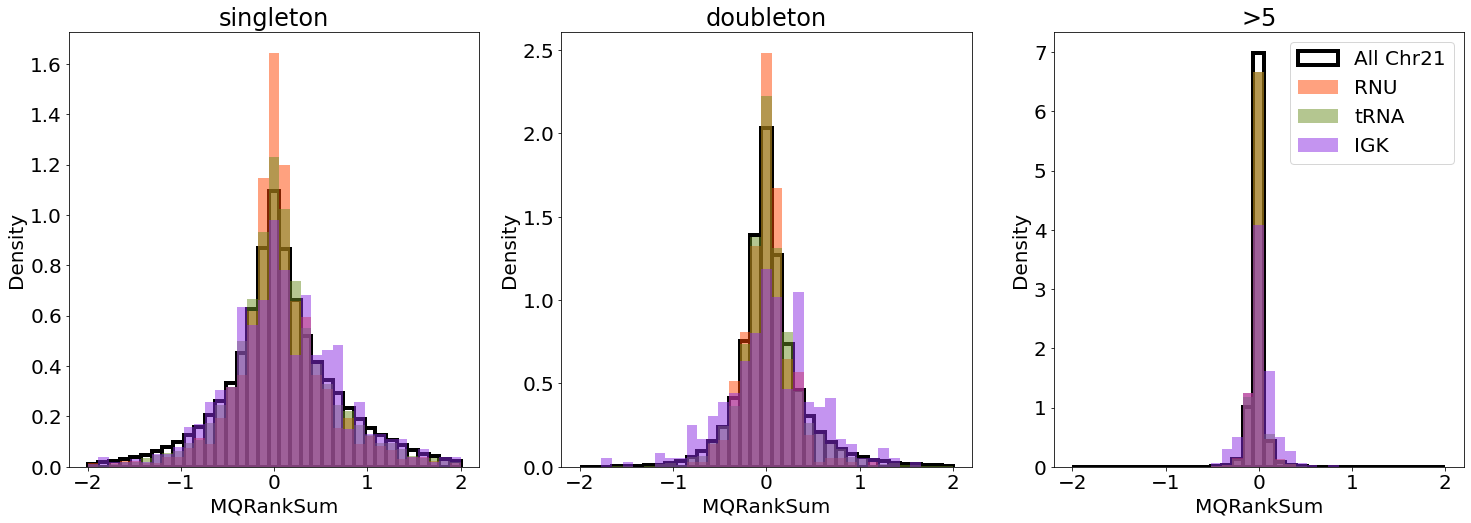

In [982]:
fig,axes = plt.subplots(1, 3, figsize=(25,8))
bins=np.linspace(-2, 2, 36)
axes[0].hist(indiv_1kg_21.loc[(indiv_1kg_21.AB!=".") & (indiv_1kg_21.AC==1)].MQRankSum.to_numpy(dtype=float), density=True, label="All Chr21", bins=bins, color="white", edgecolor="black", linewidth=4)
axes[1].hist(indiv_1kg_21.loc[(indiv_1kg_21.AB!=".") & (indiv_1kg_21.AC==2)].MQRankSum.to_numpy(dtype=float), density=True, label="All Chr21", bins=bins, color="white", edgecolor="black", linewidth=4)
axes[2].hist(indiv_1kg_21.loc[(indiv_1kg_21.AB!=".") & (indiv_1kg_21.AC>5)].MQRankSum.to_numpy(dtype=float), density=True, label="All Chr21", bins=bins, color="white", edgecolor="black", linewidth=4)

axes[0].hist(data_1kg_RNU.loc[(data_1kg_RNU.AB!=".") & (data_1kg_RNU.AC==1)].MQRankSum.to_numpy(dtype=float), alpha=0.5, density=True, label="RNU", bins=bins, color="orangered");
axes[0].hist(data_1kg_tRNA.loc[(data_1kg_tRNA.AB!=".") & (data_1kg_tRNA.AC==1)].MQRankSum.to_numpy(dtype=float), alpha=0.5, density=True, label="tRNA", bins=bins, color="olivedrab");
axes[0].hist(data_1kg_IGK.loc[(data_1kg_IGK.AB!=".") & (data_1kg_IGK.AC==1)].MQRankSum.to_numpy(dtype=float), alpha=0.5, density=True, label="IGK", bins=bins, color="blueviolet");
axes[1].hist(data_1kg_RNU.loc[(data_1kg_RNU.AB!=".") & (data_1kg_RNU.AC==2)].MQRankSum.to_numpy(dtype=float), alpha=0.5, density=True, label="RNU", bins=bins, color="orangered");
axes[1].hist(data_1kg_tRNA.loc[(data_1kg_tRNA.AB!=".") & (data_1kg_tRNA.AC==2)].MQRankSum.to_numpy(dtype=float), alpha=0.5, density=True, label="tRNA", bins=bins, color="olivedrab");
axes[1].hist(data_1kg_IGK.loc[(data_1kg_IGK.AB!=".") & (data_1kg_IGK.AC==2)].MQRankSum.to_numpy(dtype=float), alpha=0.5, density=True, label="IGK", bins=bins, color="blueviolet");
axes[2].hist(data_1kg_RNU.loc[(data_1kg_RNU.AB!=".") & (data_1kg_RNU.AC>5)].MQRankSum.to_numpy(dtype=float), alpha=0.5, density=True, label="RNU", bins=bins, color="orangered");
axes[2].hist(data_1kg_tRNA.loc[(data_1kg_tRNA.AB!=".") & (data_1kg_tRNA.AC>5)].MQRankSum.to_numpy(dtype=float), alpha=0.5, density=True, label="tRNA", bins=bins, color="olivedrab");
axes[2].hist(data_1kg_IGK.loc[(data_1kg_IGK.AB!=".") & (data_1kg_IGK.AC>5)].MQRankSum.to_numpy(dtype=float), alpha=0.5, density=True, label="IGK", bins=bins, color="blueviolet");
plt.legend()
for ii in range(3):
    axes[ii].set_xlabel("MQRankSum")
    axes[ii].set_ylabel("Density")
axes[0].set_title("singleton")
axes[1].set_title("doubleton")
axes[2].set_title(">5")

fig.savefig("MQRankSum_histograms.pdf", bbox_inches="tight")